# Regression Implementation

In [719]:
# Import necessary libraries
try:
    import re
    import os
    import glob
    import torch
    import joblib
    import pandas as pd
    import numpy as np

    import seaborn as sns
    from scipy import stats
    from itertools import groupby
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from scipy.signal import savgol_filter

    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.base import BaseEstimator, RegressorMixin
    from sklearn.inspection import PartialDependenceDisplay
    from sklearn.preprocessing import (
        PolynomialFeatures,
        StandardScaler,
        MinMaxScaler,
        OrdinalEncoder,
        OneHotEncoder,
        LabelEncoder
    )
    from sklearn.compose import ColumnTransformer
    from sklearn.utils import class_weight
    from sklearn.linear_model import (
        LinearRegression, LogisticRegression        # Baseline models
    )
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.cluster import KMeans
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error,
        root_mean_squared_error,
        classification_report,
        confusion_matrix,
        accuracy_score,
        silhouette_score,
        precision_score,
        recall_score,
        f1_score,
        r2_score
    )
    from xgboost import XGBRegressor
    from kneed import KneeLocator
    from imblearn.over_sampling import SMOTE

    # TensorFlow and Keras for the Neural Network
    import keras
    import tensorflow as tf
    from tensorflow.keras.models import Sequential                            # type: ignore
    from tensorflow.keras import layers, models, regularizers                 # type: ignore
    from tensorflow.keras.layers import (                                     # type: ignore
        Dense, Dropout, BatchNormalization, Input
    )
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau   # type: ignore
    from tensorflow.keras.optimizers import Adam                              # type: ignore

    # Set random seeds for reproducibility
    random_state = 42
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

except Exception as e:
    print(f"Error importing libraries: {e}")

In [720]:
# Set the model saving path
# TODO: Add Google Colab support
destination = '../Models/'                       # Destination folder for the model
os.makedirs(destination, exist_ok=True)          # Create the folder if it doesn't exist
print(f"Model will be saved to: {destination}")  # Output the model destination folder

Model will be saved to: ../Models/


In [721]:
# Define color palette for the plots
green = '#2ECC71'  # Green
blue = '#3498DB'   # Blue
red = '#E74C3C'    # Red

#### Function defintion

Custom-made functions in this notebook offer several benefits that enhance the efficiency, readability, and maintainability of the code. By encapsulating specific tasks into functions, we achieve modularity, which allows for easier debugging and testing. Functions such as `regression_evaluation`, `load_dataset`, and `one_hot_encoding` streamline repetitive tasks, ensuring consistency and reducing the likelihood of errors. Additionally, these functions improve code reusability, enabling us to apply the same logic across different parts of the notebook without redundancy. This approach not only saves time but also makes the notebook more organized and easier to understand for collaborators and future reference.

In [722]:
def regression_evaluation(model, X, y, message="Model", scale=False):
    if scale:
        scaler = StandardScaler()
        X = pd.DataFrame(
            scaler.fit_transform(X),
            columns=X.columns,
            index=X.index
        )

    # Get predictions - handle both sklearn and keras models
    if isinstance(model, tf.keras.Model):
        predictions = model.predict(X, verbose=0).flatten()  # Add flatten() here
    else:
        predictions = model.predict(X)
    
    # Convert predictions to 1D array if needed
    if isinstance(predictions, np.ndarray) and predictions.ndim > 1:
        predictions = predictions.flatten()
    
    if isinstance(model, tf.keras.Model):
        predictions = model.predict(X, verbose=0)
        print(f"Raw predictions shape        : {predictions.shape}")
        predictions = predictions.flatten()
        print(f"Flattened predictions shape  : {predictions.shape}")
        print(f"Target shape                 : {y.shape}\n")

    # Calculate residuals
    residuals = y - predictions
    
    # Calculate metrics
    rmse = root_mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
    

    title = f"--- {message} Evaluation Metrics ---"
    # Print evaluation metrics
    print(f"{title}")
    print(f"-"*len(title))
    print(f"    RMSE: {rmse:.2f}")
    print(f"    R²  : {r2:.2f}")
    print(f"    MAE : {mae:.2f}")
    print(f"-"*len(title))
    
    # Set style
    plt.style.use('default')
    
    # Create figure with three subplots
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    fig.suptitle(f'Regression Model Evaluation - {message}', fontsize=14, y=1.05)
    
    # Color palette
    actual_color = '#2ECC71'  # Green
    pred_color = '#3498DB'    # Blue
    trend_color = '#E74C3C'   # Red
    
    # Plot 1: Actual vs Predicted
    line_x = np.linspace(y.min(), y.max(), 100)
    
    ax1.scatter(y, predictions, alpha=0.5, color=pred_color, label='Predictions', s=100)
    ax1.plot(line_x, line_x, '--', color='gray', alpha=0.8, label='Perfect Prediction', linewidth=2)
    
    z = np.polyfit(y, predictions, 1)
    p = np.poly1d(z)
    ax1.plot(line_x, p(line_x), '-', color=trend_color, alpha=0.8, label='Trend Line')
    
    ax1.set_xlabel('Actual Values', fontsize=12)
    ax1.set_ylabel('Predicted Values', fontsize=12)
    ax1.set_title('Actual vs Predicted Values', fontsize=13, pad=15)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    ax2.scatter(predictions, residuals, alpha=0.5, color=pred_color, s=100)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.8)
    
    z = np.polyfit(predictions, residuals, 1)
    p = np.poly1d(z)
    ax2.plot(predictions, p(predictions), color=trend_color, alpha=0.8, label='Trend Line')
    
    ax2.set_xlabel('Predicted Values', fontsize=12)
    ax2.set_ylabel('Residuals', fontsize=12)
    ax2.set_title('Residuals Plot', fontsize=13, pad=15)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    std_dev = np.std(residuals)
    ax2.axhline(y=std_dev, color=trend_color, linestyle=':', alpha=0.5, label='+1 Std Dev')
    ax2.axhline(y=-std_dev, color=trend_color, linestyle=':', alpha=0.5, label='-1 Std Dev')
    
    # Plot 3: Model Fit Visualisation
    # Sort by target values for smooth curve
    sort_idx = np.argsort(y)
    y_sorted = y.iloc[sort_idx]
    pred_sorted = predictions[sort_idx]
    
    # Create index for x-axis
    x_range = np.arange(len(y))
    
    # Plot actual and predicted values
    ax3.scatter(x_range, y_sorted, alpha=0.5, color=actual_color, label='Actual Values', s=100)
    ax3.scatter(x_range, pred_sorted, alpha=0.5, color=pred_color, label='Predictions', s=100)
    
    # Add smoothed curve through predictions
    window = len(y) // 20  # Adjust window size as needed
    if window % 2 == 0:
        window += 1
    smoothed = savgol_filter(pred_sorted, window, 3)
    ax3.plot(x_range, smoothed, '-', color=trend_color, alpha=0.8, label='Model Fit', linewidth=2)
    
    ax3.set_xlabel('Ordered Samples', fontsize=12)
    ax3.set_ylabel('Values', fontsize=12)
    ax3.set_title('Model Fit Visualisation', fontsize=13, pad=15)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    del X, y, predictions, rmse, r2, mae # Clear memory

Example usage: `regression_evaluation(model, X_test_reg, y_test_reg, "Your message here")`

Key features of this evaluation function:

1. Supports optional feature scaling
2. Calculates key metrics ($\text{RMSE}$, $\text{R}^2$ and $\text{MAE}$)
3. Creates three different visualisations for model performance analysis
4. Uses consistent color coding (green for actual, blue for predictions, red for trend lines)
5. Includes error bands ($±1$ standard deviation) in residuals plot
6. Uses **Savitzky-Golay** filtering for smoothing the model fit visualisation

This is a comprehensive evaluation function that provides both numerical metrics and visual analysis tools to understand model performance, residual patterns, and fit quality.

In [723]:
# Utility function to load dataset
# TODO: Add Google Colab support
def load_dataset(data_path='../Datasets/*.csv'):       # Dynamically load dataset from the Datasets directory
    file_list = glob.glob(data_path)
    if len(file_list) == 1:
        df = pd.read_csv(file_list[0])
        print(f"Loaded dataset: {file_list[0]}")
    else:
        raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")
    return df

In [724]:
# Function to rename columns ending with '^{1}' suffix from PolynomialFeatures
def rename_columns(df):
    new_columns = {col: col.replace('^{1}', '') for col in df.columns if col.endswith('^{1}')}
    df = df.rename(columns=new_columns)
    return df

In [725]:
# Load the dataset
df = load_dataset()

Loaded dataset: ../Datasets/Dataset.csv


In [726]:
df.head()

Lifespan partType microstructure  coolingRate  quenchTime  forgeTime  \
0   1469.17   Nozzle      equiGrain           13        3.84       6.47   
1   1793.64    Block    singleGrain           19        2.62       3.48   
2    700.60    Blade      equiGrain           28        0.76       1.34   
3   1082.10   Nozzle       colGrain            9        2.01       2.19   
4   1838.83    Blade       colGrain           16        4.13       3.87   

   HeatTreatTime  Nickel%  Iron%  Cobalt%  Chromium%  smallDefects  \
0          46.87    65.73  16.52    16.82       0.93            10   
1          44.70    54.22  35.38     6.14       4.26            19   
2           9.54    51.83  35.95     8.81       3.41            35   
3          20.29    57.03  23.33    16.86       2.78             0   
4          16.13    59.62  27.37    11.45       1.56            10   

   largeDefects  sliverDefects seedLocation    castType  
0             0              0       Bottom         Die  
1             0              0       Bottom  Investment  
2             3              0       Bottom  Investment  
3             1              0          Top  Continuous  
4             0              0          Top         Die

In [727]:
df.describe()

Lifespan  coolingRate   quenchTime    forgeTime  HeatTreatTime  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000   
mean   1298.556320    17.639000     2.764230     5.464600      30.194510   
std     340.071434     7.491783     1.316979     2.604513      16.889415   
min     417.990000     5.000000     0.500000     1.030000       1.030000   
25%    1047.257500    11.000000     1.640000     3.170000      16.185000   
50%    1266.040000    18.000000     2.755000     5.475000      29.365000   
75%    1563.050000    24.000000     3.970000     7.740000      44.955000   
max    2134.530000    30.000000     4.990000    10.000000      59.910000   

           Nickel%        Iron%      Cobalt%    Chromium%  smallDefects  \
count  1000.000000  1000.000000  1000.000000  1000.000000   1000.000000   
mean     60.243080    24.553580    12.434690     2.768650     17.311000   
std       5.790475     7.371737     4.333197     1.326496     12.268365   
min      50.020000     6.660000     5.020000     0.510000      0.000000   
25%      55.287500    19.387500     8.597500     1.590000      7.000000   
50%      60.615000    24.690000    12.585000     2.865000     18.000000   
75%      65.220000    29.882500    16.080000     3.922500     26.000000   
max      69.950000    43.650000    19.990000     4.990000     61.000000   

       largeDefects  sliverDefects  
count   1000.000000    1000.000000  
mean       0.550000       0.292000  
std        1.163982       1.199239  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        0.000000       0.000000  
75%        0.000000       0.000000  
max        4.000000       8.000000

In [728]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lifespan        1000 non-null   float64
 1   partType        1000 non-null   object 
 2   microstructure  1000 non-null   object 
 3   coolingRate     1000 non-null   int64  
 4   quenchTime      1000 non-null   float64
 5   forgeTime       1000 non-null   float64
 6   HeatTreatTime   1000 non-null   float64
 7   Nickel%         1000 non-null   float64
 8   Iron%           1000 non-null   float64
 9   Cobalt%         1000 non-null   float64
 10  Chromium%       1000 non-null   float64
 11  smallDefects    1000 non-null   int64  
 12  largeDefects    1000 non-null   int64  
 13  sliverDefects   1000 non-null   int64  
 14  seedLocation    1000 non-null   object 
 15  castType        1000 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 125.1+ KB


In [729]:
df.shape

(1000, 16)

In [730]:
# Check for missing values
df.isnull().sum()

Lifespan          0
partType          0
microstructure    0
coolingRate       0
quenchTime        0
forgeTime         0
HeatTreatTime     0
Nickel%           0
Iron%             0
Cobalt%           0
Chromium%         0
smallDefects      0
largeDefects      0
sliverDefects     0
seedLocation      0
castType          0
dtype: int64

In [731]:
# Using nunique()
num_parts = df['partType'].nunique()
print(f"Number of unique parts types: {num_parts}")

# Or using value_counts() to see the distribution
parts_distribution = df['partType'].value_counts()
print("\nDistribution of parts types:")
print(parts_distribution)

Number of unique parts types: 4

Distribution of parts types:
partType
Valve     265
Block     253
Nozzle    245
Blade     237
Name: count, dtype: int64


In [732]:
unique_lifespan_count = df['Lifespan'].nunique()
print(f"Number of unique values in 'Lifespan' column: {unique_lifespan_count}")

Number of unique values in 'Lifespan' column: 998


In [733]:
# Find the unique values that occur more than once in the 'Lifespan' column
duplicate_values = df['Lifespan'].value_counts()
duplicate_values = duplicate_values[duplicate_values > 1]

# Output the unique values and their counts
print(duplicate_values)

Lifespan
1262.14    2
932.69     2
Name: count, dtype: int64


We have found that there are 4 disticnt metal parts in this dataset.

### Distribution of Lifespan

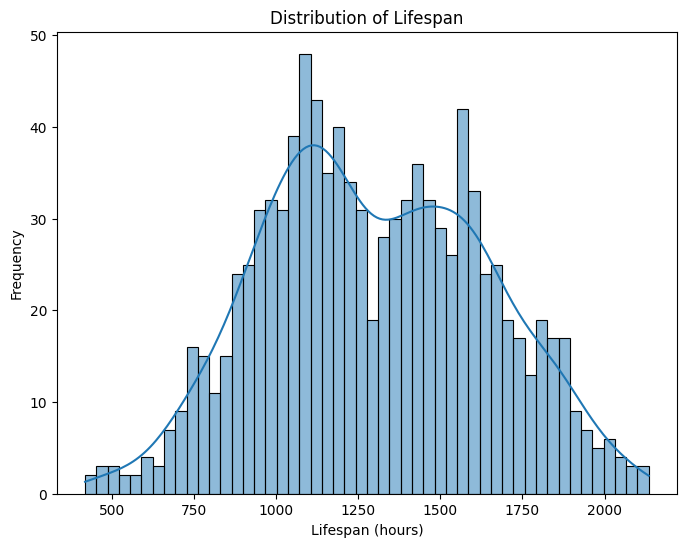

In [734]:
bins = 50

# Plotting the distribution of 'Lifespan'
plt.figure(figsize=(8, 6))
sns.histplot(df['Lifespan'], bins=bins, kde=True)
plt.title('Distribution of Lifespan')
plt.xlabel('Lifespan (hours)')
plt.ylabel('Frequency')
plt.show()

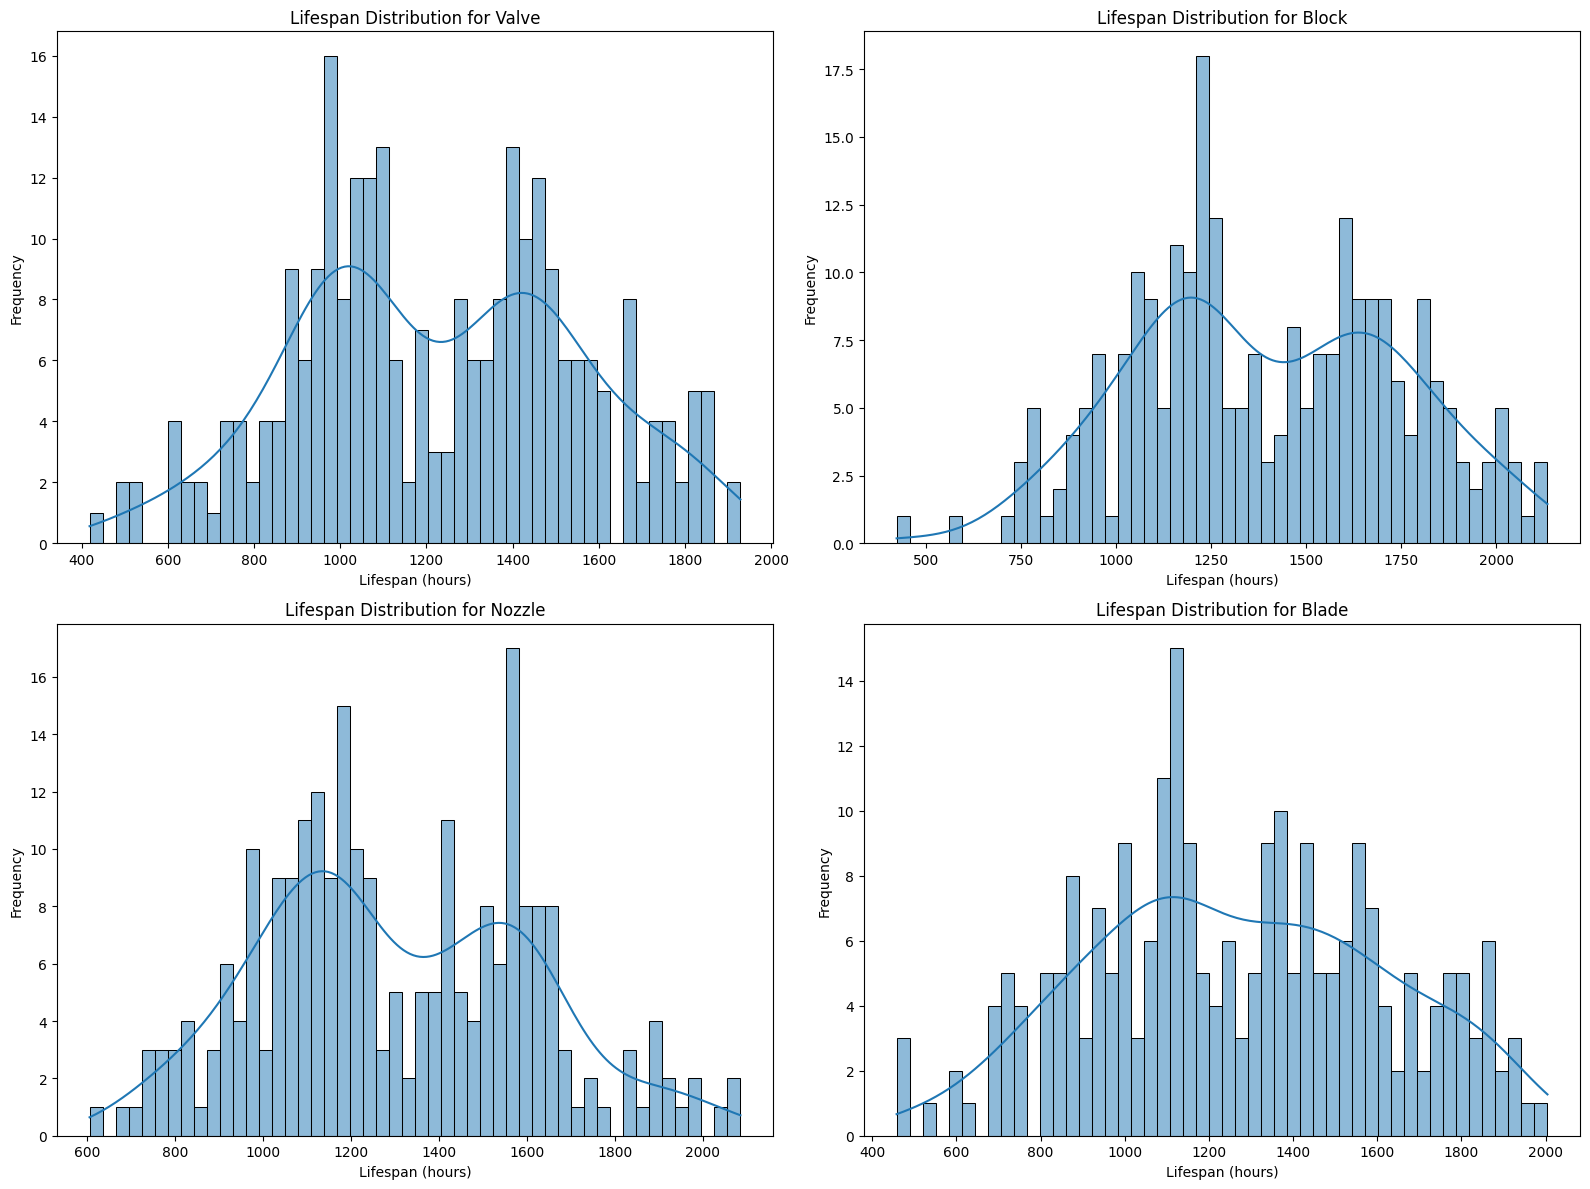

In [735]:
# List of metal parts
part_types = ['Valve', 'Block', 'Nozzle', 'Blade']

# Set up the subplots: 2 rows and 2 columns (one for each metal part)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each metal part and create a histogram for its lifespan distribution
for i, part in enumerate(part_types):
    subset = df[df['partType'] == part]
    sns.histplot(subset['Lifespan'], bins=bins, kde=True, ax=axes[i])
    axes[i].set_title(f'Lifespan Distribution for {part}')
    axes[i].set_xlabel('Lifespan (hours)')
    axes[i].set_ylabel('Frequency')

# Adjust layout for better visualisation
plt.tight_layout()
plt.show()

In [736]:
# List of numerical columns excluding 'Lifespan'
numerical_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'Lifespan']
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

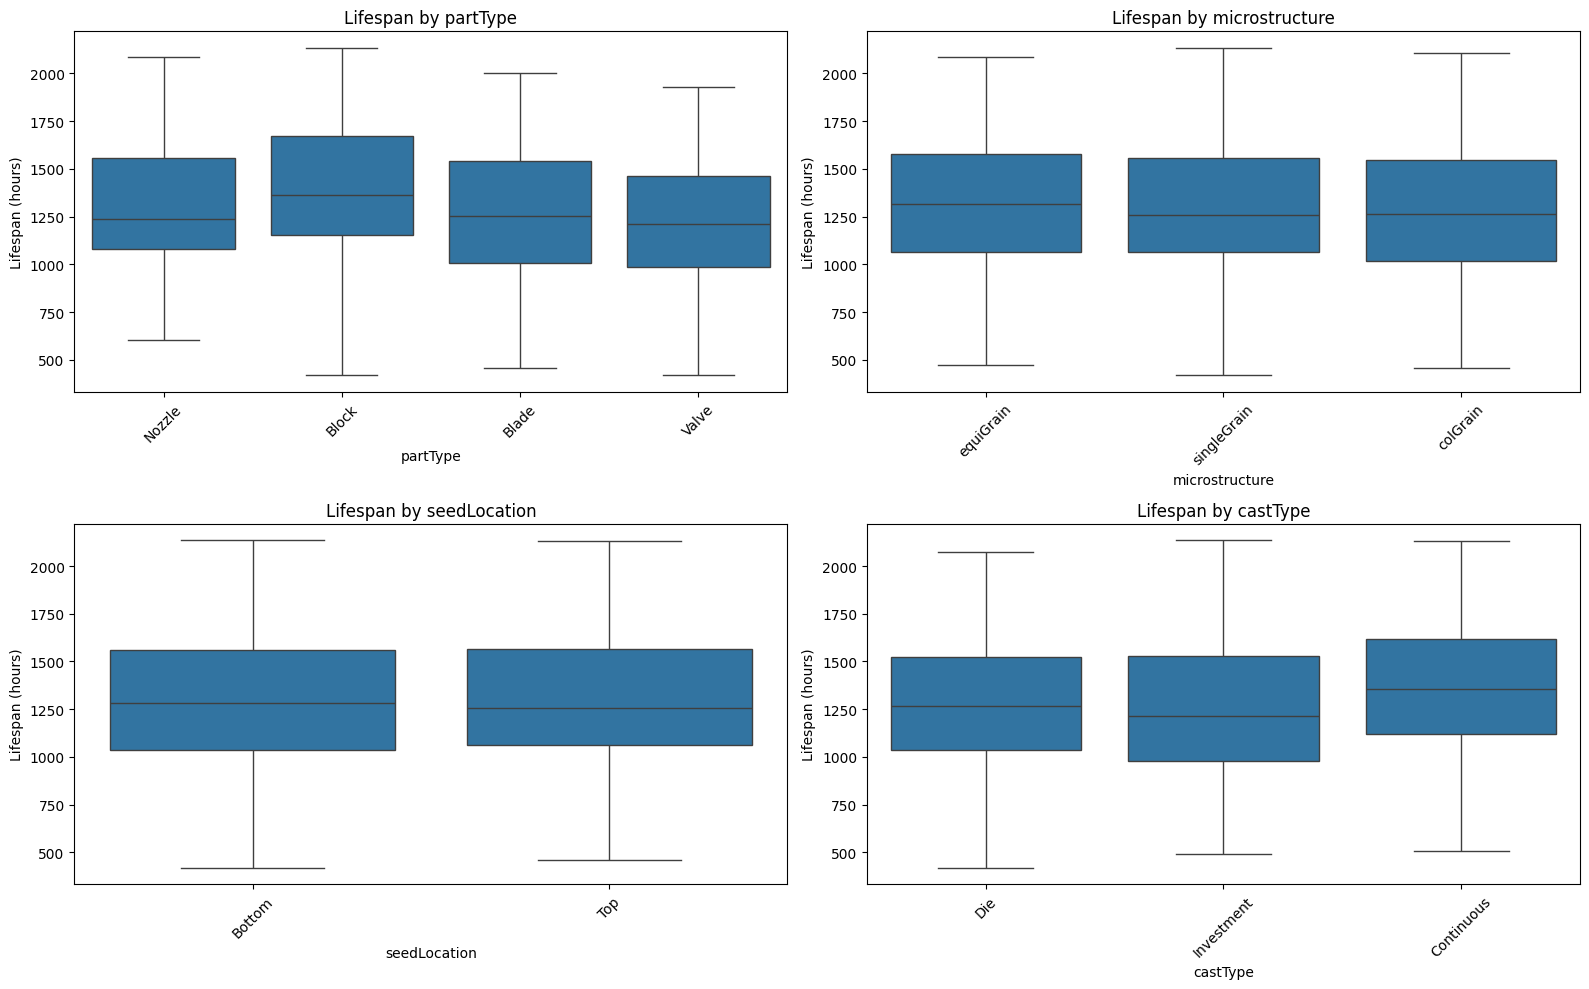

In [737]:
# Determine the number of rows and columns for the subplots
num_cols = len(categorical_features)
nrows = num_cols // 2 + (num_cols % 2 > 0)  # Set up for 2 columns per row for better readability

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, nrows * 5))
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Plot each boxplot in a different subplot
for i, col in enumerate(categorical_features):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=df)
    axes[i].set_title(f'Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots if the number of features is odd
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualisation
plt.tight_layout()
plt.show()

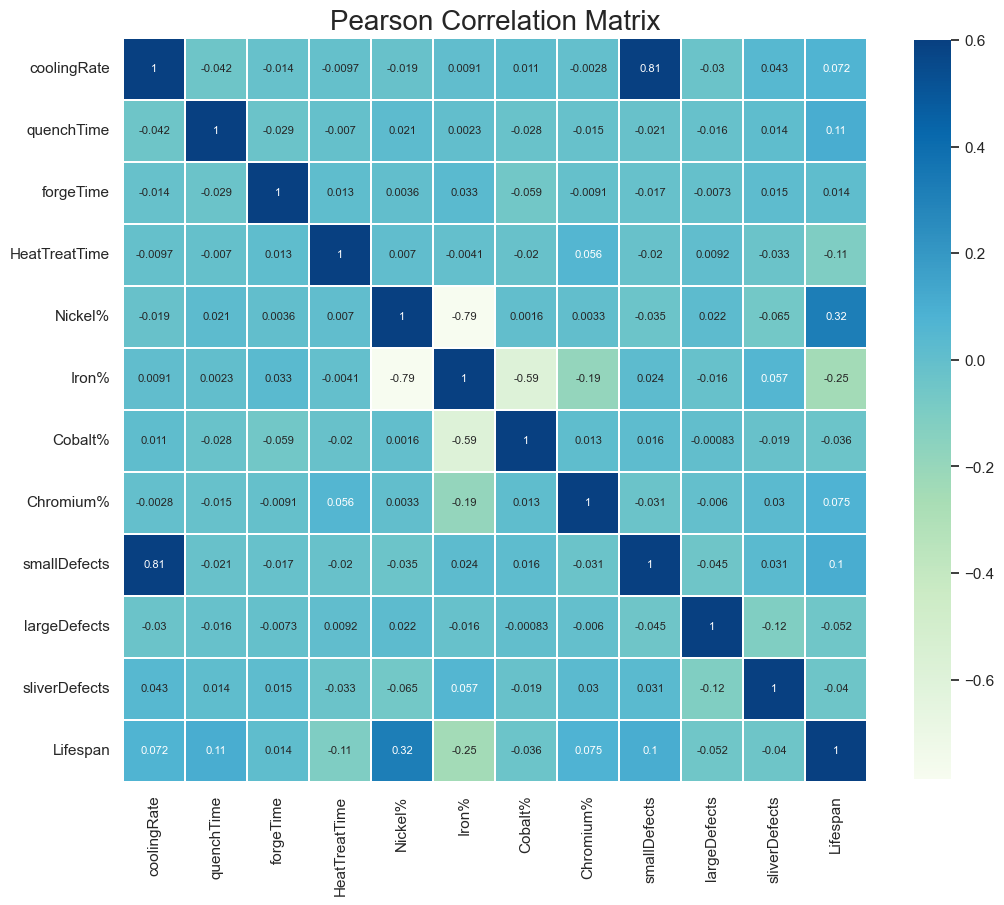

In [738]:
# Include 'Lifespan' in the correlation matrix
numerical_cols_with_target = numerical_features + ['Lifespan']
corr_matrix = df[numerical_cols_with_target].corr()

sns.set_theme(style="whitegrid", font_scale=1)

plt.figure(figsize=(12,12))
plt.title('Pearson Correlation Matrix',fontsize=20)
sns.heatmap(corr_matrix,linewidths=0.25,vmax=0.6,square=True,cmap="GnBu",linecolor='w',
            annot=True, annot_kws={"size":8}, cbar_kws={"shrink": .8})
plt.show()

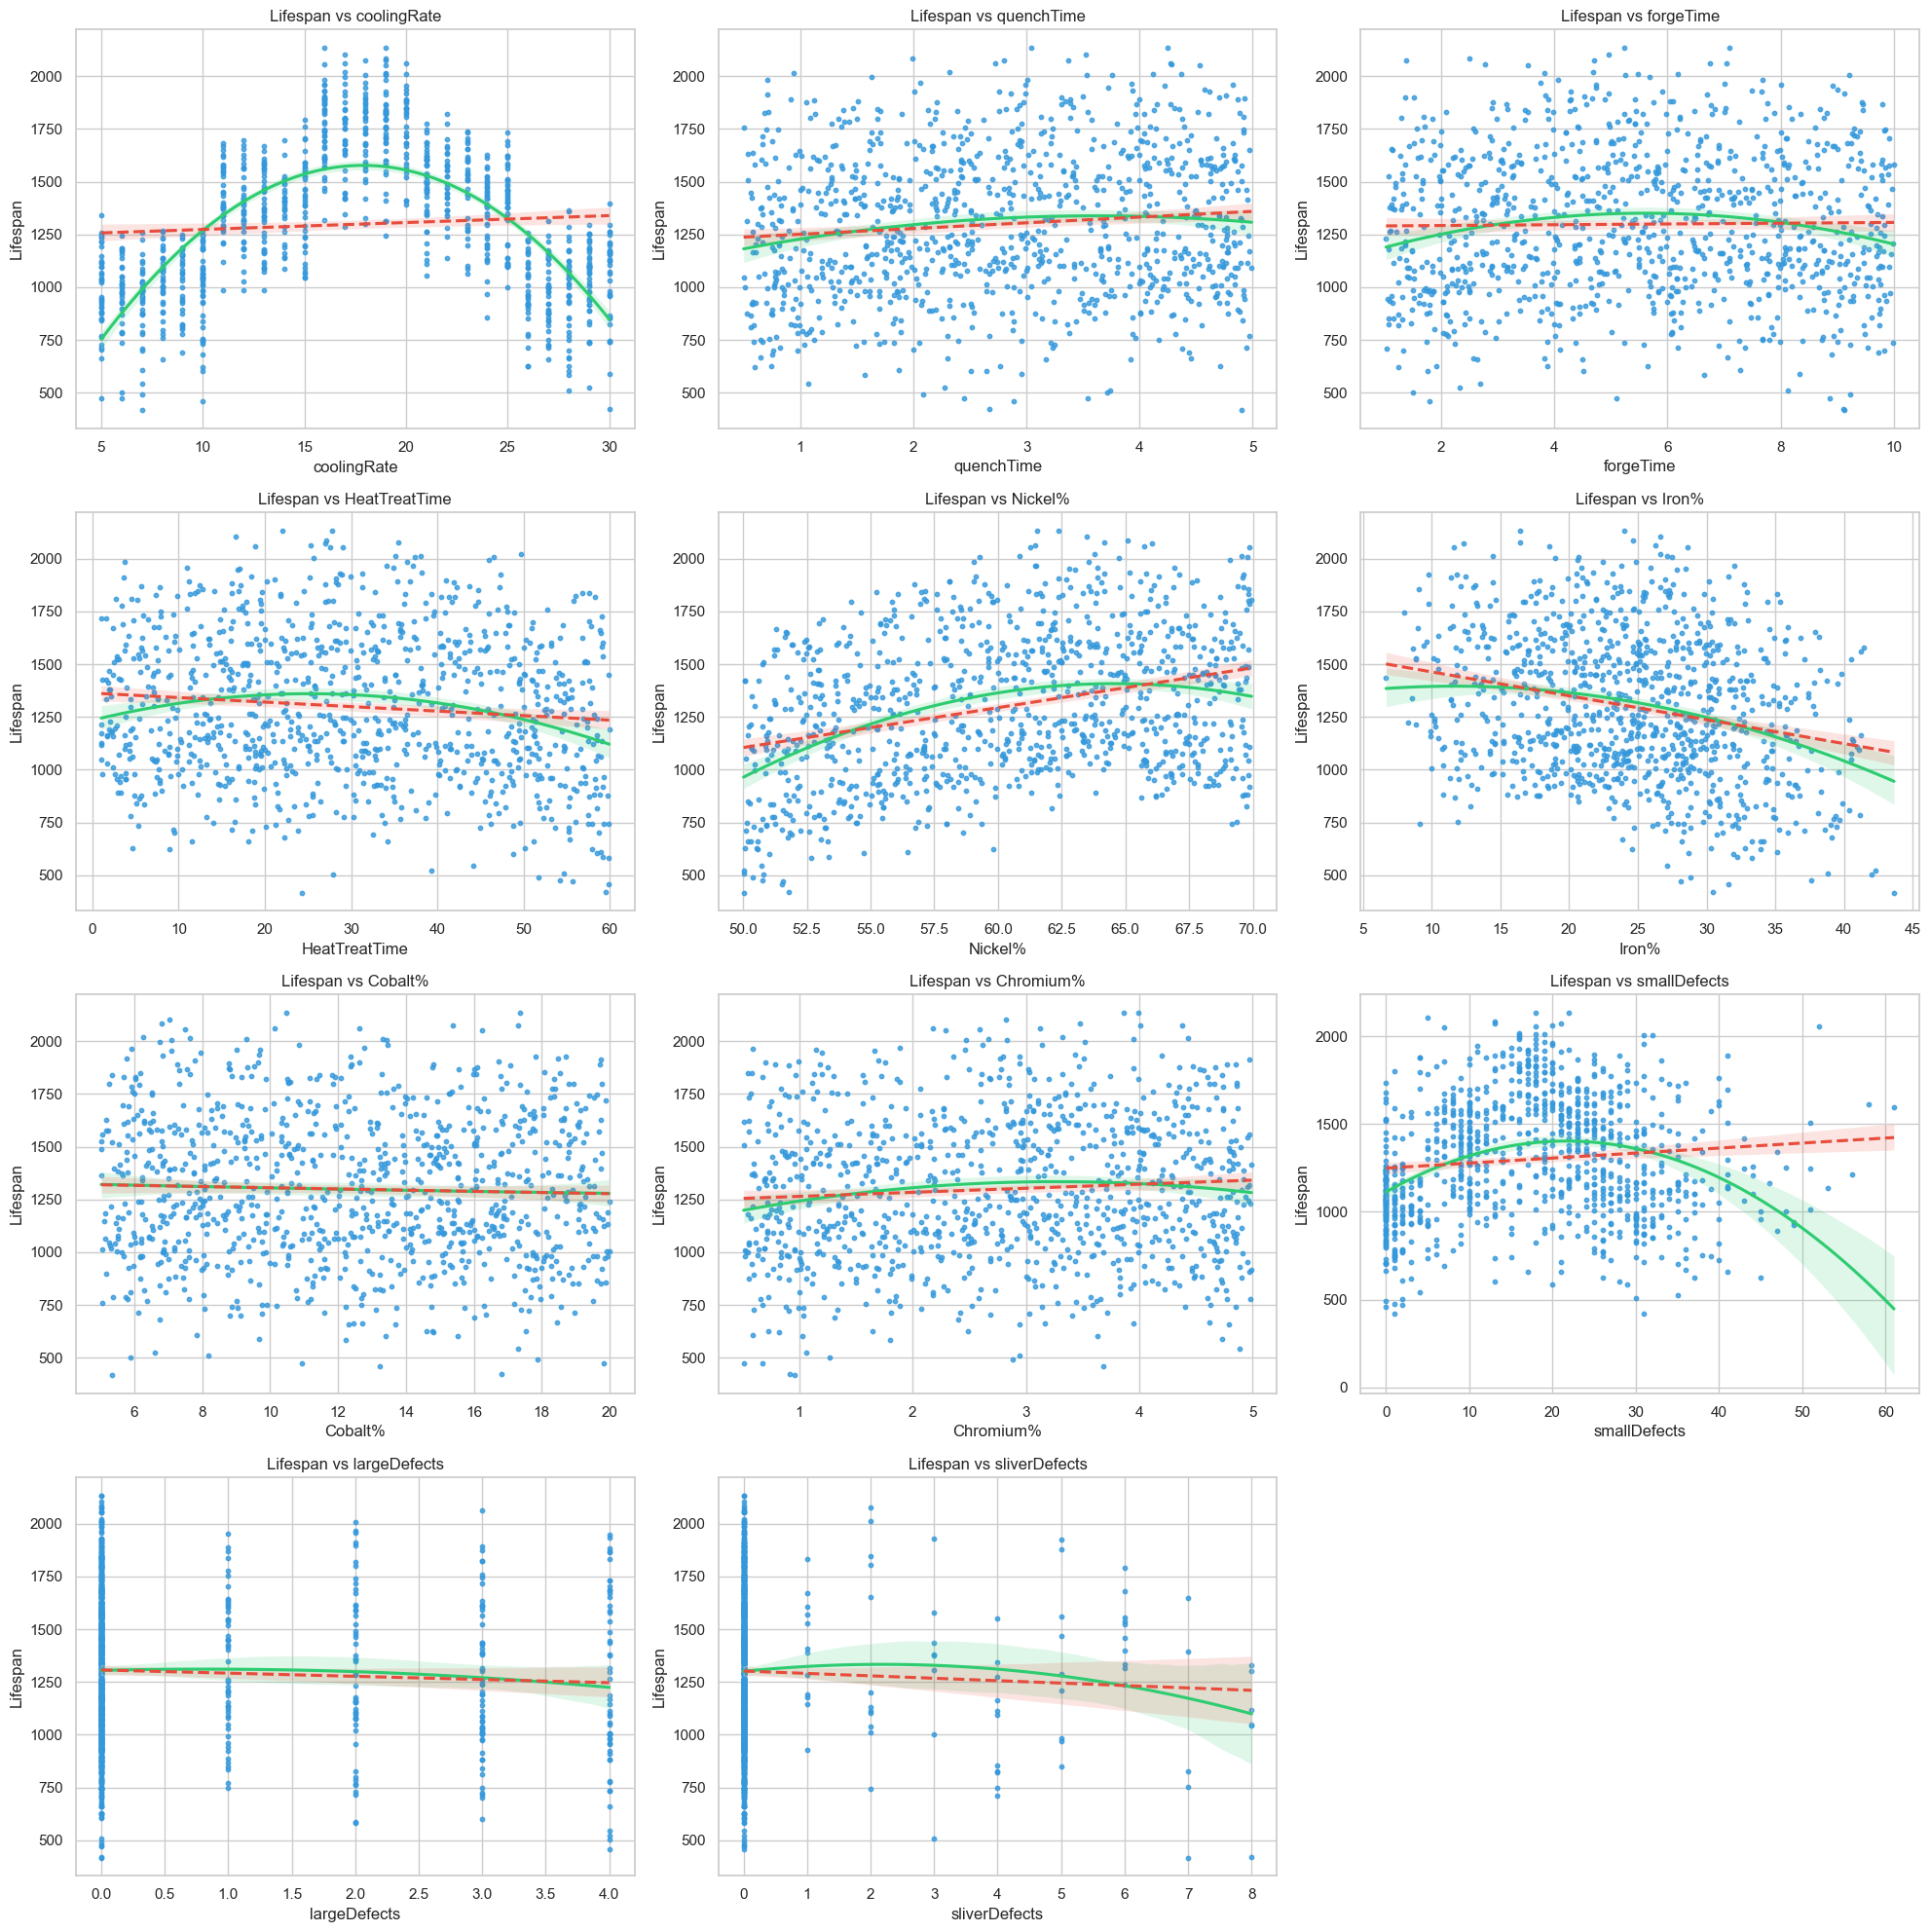

In [739]:
# Determine the number of rows and columns for the subplots
num_cols = len(numerical_features)
nrows = num_cols // 3 + (num_cols % 3 > 0)  # Set up for 3 columns per row

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows * 5))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot each scatterplot with a polynomial regression trend line in a different subplot
for i, col in enumerate(numerical_features):
    sns.regplot(
        ax=axes[i],
        data=df,
        x=col,
        y='Lifespan',
        scatter_kws={'s': 10, 'color': blue},  # Set scatter plot color to blue
        line_kws={'color': green},
        order=2  # Using polynomial order 2 to create a curved trend line
    )
    axes[i].set_title(f'Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')

    # Linear regression line
    sns.regplot(ax=axes[i], data=df, x=col, y='Lifespan', scatter=False, line_kws={'color': red, 'linestyle': '--'})

# Remove any empty subplots if the number of features is not perfectly divisible by 3
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualisation
plt.tight_layout()
plt.show()

There is a parabolic (U-shaped) trend visible, which confirms your earlier findings. This suggests that there is an optimal cooling rate where the lifespan reaches a peak, beyond which the lifespan decreases. A quadratic relationship fits well here.

In [740]:
# Define features to transform
features_to_transform = {
    'coolingRate': 7,
    'forgeTime': 2,
    'HeatTreatTime': 2,
    'smallDefects': 3,
    'sliverDefects': 2
}

# Keep a copy of original features
df_transformed = df.copy()

# Transform features using PolynomialFeatures
for feature, degree in features_to_transform.items():
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[[feature]])
    
    # Get column names for the new polynomial features
    poly_feature_names = [f"{feature}^{{{i}}}" for i in range(1, degree + 1)]
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    
    # Drop the original feature and add polynomial features to the dataset
    df_transformed = df_transformed.drop(columns=[feature]).join(poly_df)

# Adding linear features that were not transformed back to the transformed DataFrame
# Only add features that were not involved in polynomial transformation
linear_features = ['quenchTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'largeDefects']
df_transformed = df_transformed[linear_features + [col for col in df_transformed.columns if col not in linear_features]]

# The df_transformed now contains both the polynomial and linear features without redundancy
display(df_transformed.head())
display(df.head())

quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects  Lifespan  \
0        3.84    65.73  16.52    16.82       0.93             0   1469.17   
1        2.62    54.22  35.38     6.14       4.26             0   1793.64   
2        0.76    51.83  35.95     8.81       3.41             3    700.60   
3        2.01    57.03  23.33    16.86       2.78             1   1082.10   
4        4.13    59.62  27.37    11.45       1.56             0   1838.83   

  partType microstructure seedLocation  ... coolingRate^{7}  forgeTime^{1}  \
0   Nozzle      equiGrain       Bottom  ...    6.274852e+07           6.47   
1    Block    singleGrain       Bottom  ...    8.938717e+08           3.48   
2    Blade      equiGrain       Bottom  ...    1.349293e+10           1.34   
3   Nozzle       colGrain          Top  ...    4.782969e+06           2.19   
4    Blade       colGrain          Top  ...    2.684355e+08           3.87   

   forgeTime^{2}  HeatTreatTime^{1}  HeatTreatTime^{2}  smallDefects^{1}  \
0        41.8609              46.87          2196.7969              10.0   
1        12.1104              44.70          1998.0900              19.0   
2         1.7956               9.54            91.0116              35.0   
3         4.7961              20.29           411.6841               0.0   
4        14.9769              16.13           260.1769              10.0   

   smallDefects^{2}  smallDefects^{3}  sliverDefects^{1}  sliverDefects^{2}  
0             100.0            1000.0                0.0                0.0  
1             361.0            6859.0                0.0                0.0  
2            1225.0           42875.0                0.0                0.0  
3               0.0               0.0                0.0                0.0  
4             100.0            1000.0                0.0                0.0  

[5 rows x 27 columns]

Lifespan partType microstructure  coolingRate  quenchTime  forgeTime  \
0   1469.17   Nozzle      equiGrain           13        3.84       6.47   
1   1793.64    Block    singleGrain           19        2.62       3.48   
2    700.60    Blade      equiGrain           28        0.76       1.34   
3   1082.10   Nozzle       colGrain            9        2.01       2.19   
4   1838.83    Blade       colGrain           16        4.13       3.87   

   HeatTreatTime  Nickel%  Iron%  Cobalt%  Chromium%  smallDefects  \
0          46.87    65.73  16.52    16.82       0.93            10   
1          44.70    54.22  35.38     6.14       4.26            19   
2           9.54    51.83  35.95     8.81       3.41            35   
3          20.29    57.03  23.33    16.86       2.78             0   
4          16.13    59.62  27.37    11.45       1.56            10   

   largeDefects  sliverDefects seedLocation    castType  
0             0              0       Bottom         Die  
1             0              0       Bottom  Investment  
2             3              0       Bottom  Investment  
3             1              0          Top  Continuous  
4             0              0          Top         Die

In [741]:
def print_transformed_columns_info(df_transformed):
    for col in df_transformed.columns:
        print(f"- {col}")
    print(f"Number of columns: {len(df_transformed.columns)}")

# Call the function to print the transformed columns info
print_transformed_columns_info(df_transformed)

- quenchTime
- Nickel%
- Iron%
- Cobalt%
- Chromium%
- largeDefects
- Lifespan
- partType
- microstructure
- seedLocation
- castType
- coolingRate^{1}
- coolingRate^{2}
- coolingRate^{3}
- coolingRate^{4}
- coolingRate^{5}
- coolingRate^{6}
- coolingRate^{7}
- forgeTime^{1}
- forgeTime^{2}
- HeatTreatTime^{1}
- HeatTreatTime^{2}
- smallDefects^{1}
- smallDefects^{2}
- smallDefects^{3}
- sliverDefects^{1}
- sliverDefects^{2}
Number of columns: 27


In [742]:
df1_test = df_transformed[['coolingRate^{1}', 'forgeTime^{1}', 'HeatTreatTime^{1}', 'smallDefects^{1}', 'sliverDefects^{1}']]
df2_test = df_transformed[['coolingRate^{6}', 'forgeTime^{2}', 'HeatTreatTime^{2}', 'smallDefects^{3}', 'sliverDefects^{2}']]

display(df1_test.head())
display(df2_test.head())

coolingRate^{1}  forgeTime^{1}  HeatTreatTime^{1}  smallDefects^{1}  \
0             13.0           6.47              46.87              10.0   
1             19.0           3.48              44.70              19.0   
2             28.0           1.34               9.54              35.0   
3              9.0           2.19              20.29               0.0   
4             16.0           3.87              16.13              10.0   

   sliverDefects^{1}  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

coolingRate^{6}  forgeTime^{2}  HeatTreatTime^{2}  smallDefects^{3}  \
0        4826809.0        41.8609          2196.7969            1000.0   
1       47045881.0        12.1104          1998.0900            6859.0   
2      481890304.0         1.7956            91.0116           42875.0   
3         531441.0         4.7961           411.6841               0.0   
4       16777216.0        14.9769           260.1769            1000.0   

   sliverDefects^{2}  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

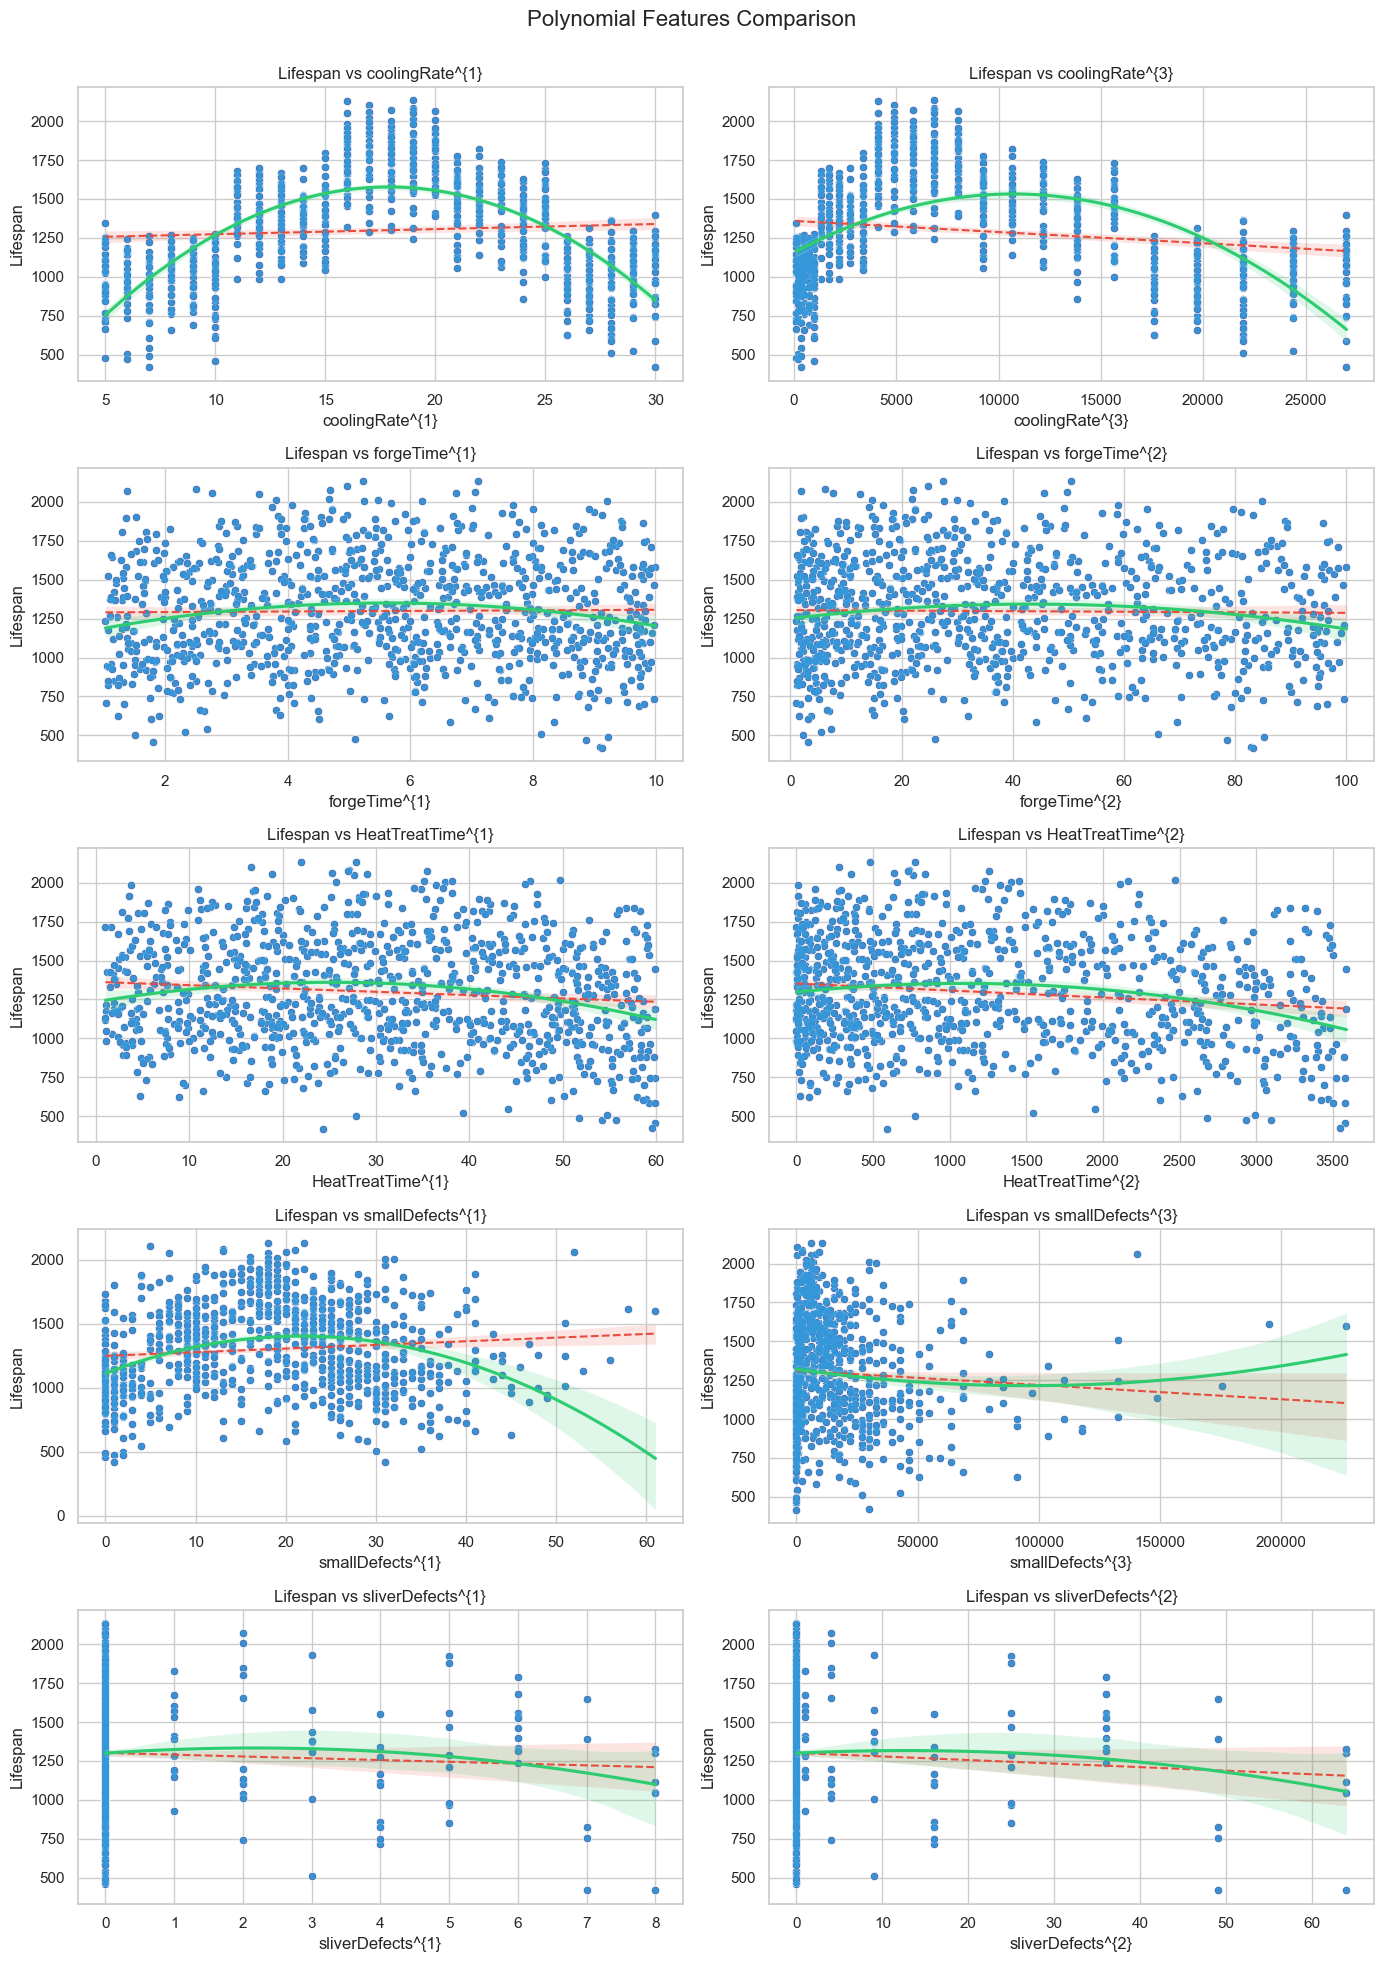

In [743]:
# Scatter plots for the newly added polynomial features vs. Lifespan.

# List of newly created polynomial features
polynomial_features = [
    'coolingRate^{1}', 'coolingRate^{3}', 
    'forgeTime^{1}', 'forgeTime^{2}', 
    'HeatTreatTime^{1}', 'HeatTreatTime^{2}', 
    'smallDefects^{1}', 'smallDefects^{3}', 
    'sliverDefects^{1}', 'sliverDefects^{2}'
]

# Number of rows and columns for the plot grid
n_cols = 2
n_rows = len(polynomial_features) // n_cols + (len(polynomial_features) % n_cols > 0)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

# Plot each polynomial feature against 'Lifespan'
for i, feature in enumerate(polynomial_features):
    row, col = divmod(i, n_cols)
    sns.scatterplot(ax=axes[row, col], x=df_transformed[feature], y=df_transformed['Lifespan'])
    sns.regplot(ax=axes[row, col], x=df_transformed[feature], y=df_transformed['Lifespan'], scatter=False, color=red, line_kws={"linewidth": 1.5, "linestyle":'--'})
    axes[row, col].set_title(f"Lifespan vs {feature}")
    sns.regplot(
        ax=axes[row, col],
        data=df_transformed,
        x=df_transformed[feature],
        y=df_transformed['Lifespan'],
        scatter_kws={'s': 10, 'color': blue},  # Set scatter plot color to blue
        line_kws={'color': green},
        order=2  # Using polynomial order 2 to create a curved trend line
    )
# Set the title for the entire figure
fig.suptitle("Polynomial Features Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust the rect parameter to make space for the title
plt.show()

In [744]:
# Define features to transform along with their degrees
features_to_transform = {
    'coolingRate': 2,    # Square the 'coolingRate' feature
    'smallDefects': 2,   # Square the 'smallDefects' feature
    # Add or remove features and degrees as needed
}

In [745]:
# Reset the dataframe
del df_transformed

# Keep a copy of original features
df_transformed = df.copy()

# Transform features using PolynomialFeatures
for feature, degree in features_to_transform.items():
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[[feature]])
    
    # Get column names for the new polynomial features
    poly_feature_names = [f"{feature}^{{{i}}}" for i in range(1, degree + 1)]
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    
    # Drop the original feature and add polynomial features to the dataset
    df_transformed = df_transformed.drop(columns=[feature]).join(poly_df)
    new_columns = {col: col.replace('^{1}', '') for col in df_transformed.columns if col.endswith('^{1}')}
    df_transformed = df_transformed.rename(columns=new_columns)

# Adding linear features that were not transformed back to the transformed DataFrame
# Only add features that were not involved in polynomial transformation
linear_features = ['quenchTime', 'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%', 'largeDefects']
df_transformed = df_transformed[linear_features + [col for col in df_transformed.columns if col not in linear_features]]

# The df_transformed now contains both the polynomial and linear features without redundancy
display(df.head())
display(df_transformed.head())

Lifespan partType microstructure  coolingRate  quenchTime  forgeTime  \
0   1469.17   Nozzle      equiGrain           13        3.84       6.47   
1   1793.64    Block    singleGrain           19        2.62       3.48   
2    700.60    Blade      equiGrain           28        0.76       1.34   
3   1082.10   Nozzle       colGrain            9        2.01       2.19   
4   1838.83    Blade       colGrain           16        4.13       3.87   

   HeatTreatTime  Nickel%  Iron%  Cobalt%  Chromium%  smallDefects  \
0          46.87    65.73  16.52    16.82       0.93            10   
1          44.70    54.22  35.38     6.14       4.26            19   
2           9.54    51.83  35.95     8.81       3.41            35   
3          20.29    57.03  23.33    16.86       2.78             0   
4          16.13    59.62  27.37    11.45       1.56            10   

   largeDefects  sliverDefects seedLocation    castType  
0             0              0       Bottom         Die  
1             0              0       Bottom  Investment  
2             3              0       Bottom  Investment  
3             1              0          Top  Continuous  
4             0              0          Top         Die

quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects  Lifespan  \
0        3.84    65.73  16.52    16.82       0.93             0   1469.17   
1        2.62    54.22  35.38     6.14       4.26             0   1793.64   
2        0.76    51.83  35.95     8.81       3.41             3    700.60   
3        2.01    57.03  23.33    16.86       2.78             1   1082.10   
4        4.13    59.62  27.37    11.45       1.56             0   1838.83   

  partType microstructure  forgeTime  HeatTreatTime  sliverDefects  \
0   Nozzle      equiGrain       6.47          46.87              0   
1    Block    singleGrain       3.48          44.70              0   
2    Blade      equiGrain       1.34           9.54              0   
3   Nozzle       colGrain       2.19          20.29              0   
4    Blade       colGrain       3.87          16.13              0   

  seedLocation    castType  coolingRate  coolingRate^{2}  smallDefects  \
0       Bottom         Die         13.0            169.0          10.0   
1       Bottom  Investment         19.0            361.0          19.0   
2       Bottom  Investment         28.0            784.0          35.0   
3          Top  Continuous          9.0             81.0           0.0   
4          Top         Die         16.0            256.0          10.0   

   smallDefects^{2}  
0             100.0  
1             361.0  
2            1225.0  
3               0.0  
4             100.0

In [746]:
print(f"Original Shape    : {df.shape}")
print(f"Transformed Shape : {df_transformed.shape}")

Original Shape    : (1000, 16)
Transformed Shape : (1000, 18)


In [747]:
# Apply the function to the dataframe
reg_df = df_transformed.copy()

def extract_features(df, target='Lifespan'):
    if target not in df.columns:
        target = 'Lifetime'
    
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    totalnum_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != target]
    polynomial_features = [col for col in df.columns if re.search(r'\^\{\d+\}$', col)]
    numerical_features = [col for col in totalnum_features if col not in polynomial_features]
    
    print(f"Target feature: {target}\n")
    
    feature_types = [
        ("Categorical features", categorical_features),
        ("Numerical features", numerical_features),
        ("Polynomial features", polynomial_features)
    ]
    
    for feature_type, features in feature_types:
        print(f"{feature_type}: {len(features)}")
        for col in features:
            print(f"- {col}")
        print()   # Add a new line for better readability
    print("Total numerical features:", len(totalnum_features))
    display(df.head())
    
    return categorical_features, totalnum_features, polynomial_features, numerical_features

categorical_features, totalnum_features, polynomial_features, numerical_features = extract_features(reg_df, target='Lifespan')

Target feature: Lifespan

Categorical features: 4
- partType
- microstructure
- seedLocation
- castType

Numerical features: 11
- quenchTime
- Nickel%
- Iron%
- Cobalt%
- Chromium%
- largeDefects
- forgeTime
- HeatTreatTime
- sliverDefects
- coolingRate
- smallDefects

Polynomial features: 2
- coolingRate^{2}
- smallDefects^{2}

Total numerical features: 13


quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects  Lifespan  \
0        3.84    65.73  16.52    16.82       0.93             0   1469.17   
1        2.62    54.22  35.38     6.14       4.26             0   1793.64   
2        0.76    51.83  35.95     8.81       3.41             3    700.60   
3        2.01    57.03  23.33    16.86       2.78             1   1082.10   
4        4.13    59.62  27.37    11.45       1.56             0   1838.83   

  partType microstructure  forgeTime  HeatTreatTime  sliverDefects  \
0   Nozzle      equiGrain       6.47          46.87              0   
1    Block    singleGrain       3.48          44.70              0   
2    Blade      equiGrain       1.34           9.54              0   
3   Nozzle       colGrain       2.19          20.29              0   
4    Blade       colGrain       3.87          16.13              0   

  seedLocation    castType  coolingRate  coolingRate^{2}  smallDefects  \
0       Bottom         Die         13.0            169.0          10.0   
1       Bottom  Investment         19.0            361.0          19.0   
2       Bottom  Investment         28.0            784.0          35.0   
3          Top  Continuous          9.0             81.0           0.0   
4          Top         Die         16.0            256.0          10.0   

   smallDefects^{2}  
0             100.0  
1             361.0  
2            1225.0  
3               0.0  
4             100.0

In [748]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int, drop=None)
encoder_le = LabelEncoder()
encoder_ord = OrdinalEncoder()
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
scaler_std = StandardScaler()
scaler_mnm = MinMaxScaler()
scaler_poly = PolynomialFeatures(degree=degree, include_bias=False)

In [749]:
# OneHotEncoder
# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', imputer_num),         # Impute missing values if any present in the dataset
    ('scaler', scaler_std)
])

# Preprocessing for categorical features
categorical_transformer_onehot = Pipeline(steps=[
    ('imputer', imputer_cat),         # Impute missing values if any present in the dataset
    ('onehot', encoder_ohe)
])

# Combine preprocessing steps
preprocessor_onehot = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, totalnum_features),
        ('cat', categorical_transformer_onehot, categorical_features)
    ],
    verbose_feature_names_out=False
)

# OrdinalEncoder
# Preprocessing for categorical features using OrdinalEncoder
categorical_transformer_label = Pipeline(steps=[
    ('imputer', imputer_cat),         # Impute missing values if any present in the dataset
    ('ordinal_encoder', encoder_ord)
])

# Combine preprocessing steps
preprocessor_ordinal = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, totalnum_features),
        ('cat', categorical_transformer_label, categorical_features)
    ],
    verbose_feature_names_out=False
)

# Hybrid Approach
# Identify 'partType' and other categorical features
key_features = ['partType']
other_categorical_features = [col for col in categorical_features if col not in key_features]

# Preprocessing pipeline for 'partType' using Label Encoding
part_type_transformer = Pipeline(steps=[
    ('imputer', imputer_cat),
    ('ordinal_encoder', encoder_ord)
])

# Preprocessing pipeline for other categorical features using One-Hot Encoding
other_categorical_transformer = Pipeline(steps=[
    ('imputer', imputer_cat),
    ('onehot', encoder_ohe)
])

# Combine preprocessing steps
preprocessor_hybrid = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, totalnum_features),
        ('part_type', part_type_transformer, key_features),
        ('cat', other_categorical_transformer, other_categorical_features)
    ],
    verbose_feature_names_out=False
)

# Preprocessor for non polynomial features
preprocessor_onehot_nonpoly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer_onehot, categorical_features)
    ]
)

In [750]:
# Set target value
target = 'Lifespan'

# Bin target into quartiles
reg_df['Lifespan_bin'] = pd.qcut(reg_df[target], q=4, duplicates='drop')

# First, split into training and temp (validation + test)
reg_train_df, temp_df = train_test_split(
    reg_df,
    test_size=0.3,
    stratify=reg_df['Lifespan_bin'],
    random_state=random_state
)

# Then, split temp_df equally into validation and test sets
reg_val_df, reg_test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['Lifespan_bin'],
    random_state=random_state
)

# Remove the temporary DataFrame
del temp_df

# Optionally, drop the temporary columns
reg_train_df = reg_train_df.drop(columns=['Lifespan_bin'])
reg_val_df = reg_val_df.drop(columns=['Lifespan_bin'])
reg_test_df = reg_test_df.drop(columns=['Lifespan_bin'])

train_shape, val_shape, test_shape = reg_train_df.shape, reg_val_df.shape, reg_test_df.shape
print(f"Training set shape   : {train_shape}")
print(f"Validation set shape : {val_shape}")
print(f"Test set shape       : {test_shape}")


Training set shape   : (700, 18)
Validation set shape : (150, 18)
Test set shape       : (150, 18)


Here, we are splitting the data into common train, validation and test sets with split ratio of $0.7$, $0.15$ and $0.15$ respectively. We are also using stratification to ensure that the distribution of the target variable is similar in all the sets especially in the train set. Furthermore, we have two additional features which extracted using the polynomial features of `coolingRate` and `smallDefects` features.

In [751]:
reg_train_df.isnull().sum()

quenchTime          0
Nickel%             0
Iron%               0
Cobalt%             0
Chromium%           0
largeDefects        0
Lifespan            0
partType            0
microstructure      0
forgeTime           0
HeatTreatTime       0
sliverDefects       0
seedLocation        0
castType            0
coolingRate         0
coolingRate^{2}     0
smallDefects        0
smallDefects^{2}    0
dtype: int64

In [752]:
# Features (X) and target (y)
X_train_reg = reg_train_df.drop(columns=['Lifespan'])   # Features excluding the target variable
y_train_reg = reg_train_df['Lifespan']                  # Target variable

# Features (X) and target (y)
X_test_reg = reg_test_df.drop(columns=['Lifespan'])     # Features excluding the target variable
y_test_reg = reg_test_df['Lifespan']                    # Target variable

# Features (X) and target (y)
X_val_reg = reg_val_df.drop(columns=['Lifespan'])       # Features excluding the target variable
y_val_reg = reg_val_df['Lifespan']                      # Target variable

# Saving the dataset without polynomial features
nonpoly_columns = [col for col in X_train_reg.columns if col not in polynomial_features]

X_train_reg_nonpoly = X_train_reg[nonpoly_columns]
X_test_reg_nonpoly = X_test_reg[nonpoly_columns]
X_val_reg_nonpoly = X_val_reg[nonpoly_columns]

In [753]:
def create_pipeline(model, encoding_type):
    if encoding_type == 'onehot':
        preprocessor = preprocessor_onehot
    elif encoding_type == 'label':
        preprocessor = preprocessor_ordinal
    elif encoding_type == 'hybrid':
        preprocessor = preprocessor_hybrid
    elif encoding_type == 'nonpoly':
        preprocessor = preprocessor_onehot_nonpoly
    else:
        raise ValueError(f"Unknown encoding type: {encoding_type}")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

In [754]:
# Initialise the Linear Regression model
LinRegModel = LinearRegression(n_jobs=-1)

# Create a pipeline for the Linear Regression model
LinRegPipeline = create_pipeline(
    LinRegModel,   # Main model to be pipelined
    'onehot'       # TODO: Change to 'label', 'hybrid', 'onehot' or 'nonploy' for performance comparison
)

# Fit the pipelined model
LinRegPipeline.fit(
    X_train_reg,    # TODO: Change to 'X_train_reg' or 'X_train_reg_nonpoly' for performance comparison.
    y_train_reg
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quenchTime', 'Nickel%',
                                                   'Iron%', 'Cobalt%',
                                                   'Chromium%', 'largeDefects',
                                                   'forgeTime', 'HeatTreatTime',
                                                   'sliverDefects',
                                                   'coolingRate',
                                                   'coolingRate^{2}',
                                                   'smallDefects',
                                                   'smallDefects^{2}']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['partType', 'microstructure',
                                                   'seedLocation',
                                                   'castType'])],
                                   verbose_feature_names_out=False)),
                ('model', LinearRegression(n_jobs=-1))])

Here the parameter `n_jobs` is set to `-1`, which means that all available cores will be used for parallel processing.

--- Linear Regression Model (Training Set) Label Encoding Evaluation Metrics ---
--------------------------------------------------------------------------------
    RMSE: 170.54
    R²  : 0.75
    MAE : 139.05
--------------------------------------------------------------------------------


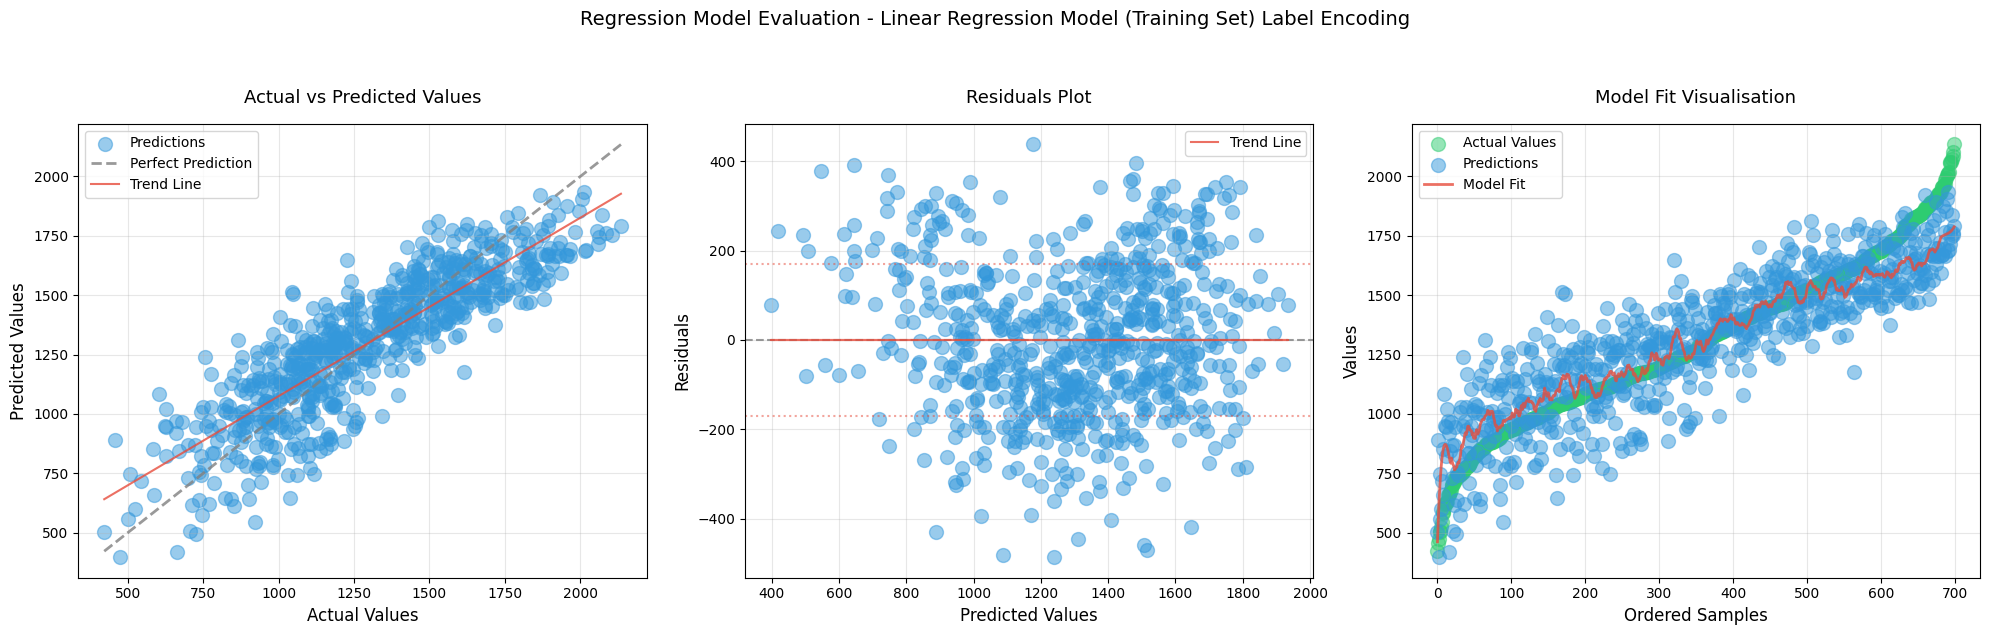

In [755]:
# Evaluate the Linear Regression model using custom function
regression_evaluation(
    LinRegPipeline,
    X_train_reg,
    y_train_reg,
    "Linear Regression Model (Training Set) Label Encoding"
)

--- Linear Regression Model (Training Set) Label Encoding Evaluation Metrics ---
--------------------------------------------------------------------------------
    RMSE: 173.29
    R²  : 0.76
    MAE : 139.51
--------------------------------------------------------------------------------


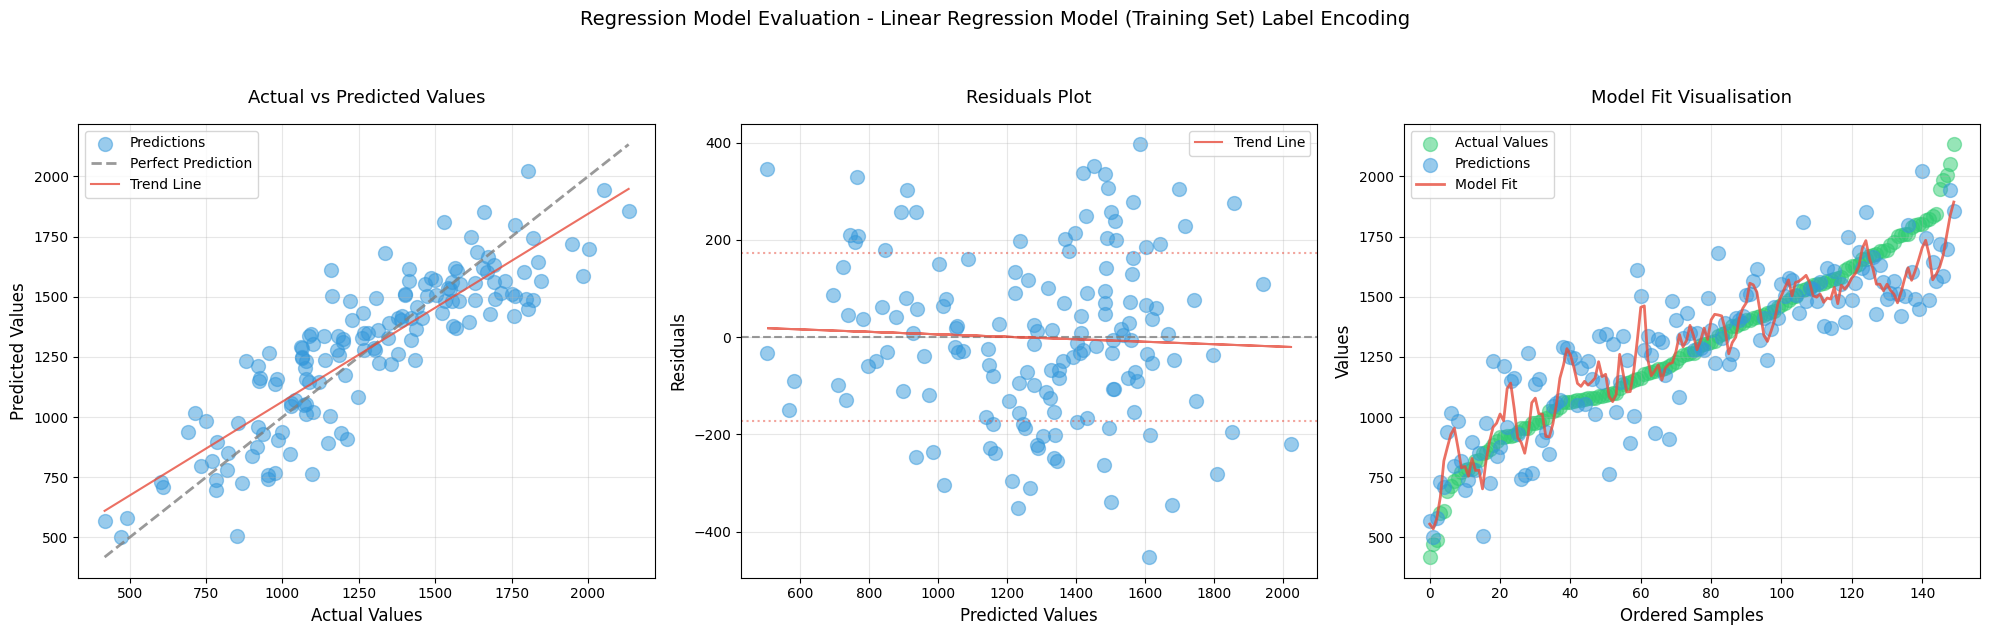

In [756]:
# Evaluate the Linear Regression model using custom function
regression_evaluation(
    LinRegPipeline,
    X_test_reg,
    y_test_reg,
    "Linear Regression Model (Training Set) Label Encoding"
)

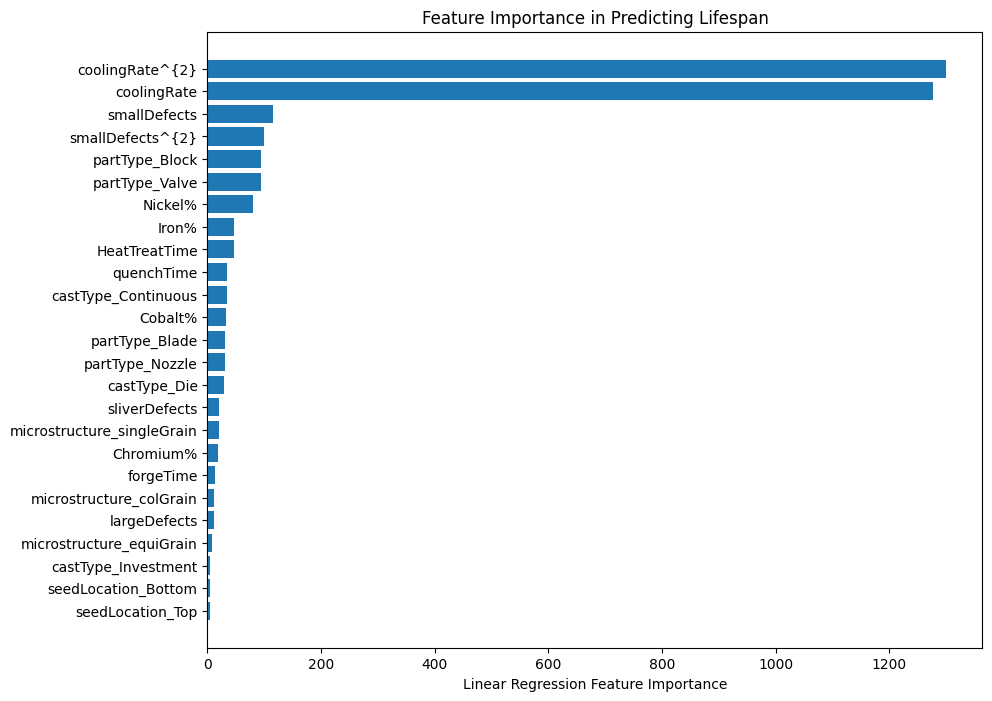

In [757]:
# Feature importance analysis
pipeline_model = LinRegPipeline
model = pipeline_model.named_steps['model']
feature_importances = np.abs(model.coef_)
feature_names = pipeline_model.named_steps['preprocessor'].get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Linear Regression Feature Importance")
plt.title(f"Feature Importance in Predicting Lifespan")
plt.show()

In [758]:
def plot_partial_dependence(
        model, X, feature_names, feature_importances, 
        n_features=3, grid_resolution=100, figsize=(15, 5), processed_data=False):
    # Create feature-importance pairs
    feature_importance_pairs = list(zip(feature_names, feature_importances))
    
    # Filter out polynomial and 'partType' features
    filtered_features = [
        (feature, importance) 
        for feature, importance in feature_importance_pairs 
        if not (
            feature.startswith('partType_') or 
            re.search(r'\^\{\d+\}$', feature)
        )
    ]
    
    # Sort by importance and get top n features
    filtered_features.sort(key=lambda x: x[1], reverse=True)
    top_features = [feature for feature, _ in filtered_features[:n_features]]
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_features, figsize=figsize)
    if n_features == 1:
        axes = [axes]
    
    # Generate partial dependence plots for each feature
    for idx, feature in enumerate(top_features):
        display = PartialDependenceDisplay.from_estimator(
            model,
            X,
            features=[feature],
            grid_resolution=grid_resolution,
            kind='both',
            ax=axes[idx]
        )
        axes[idx].set_title(f'Effect of {feature}')
        axes[idx].grid(True, linestyle='--', alpha=0.7)
    
    fig.suptitle(f'Partial Dependence Plots for Top {n_features} Features from the Dataset', y=1.05)
    plt.tight_layout()
    plt.show()


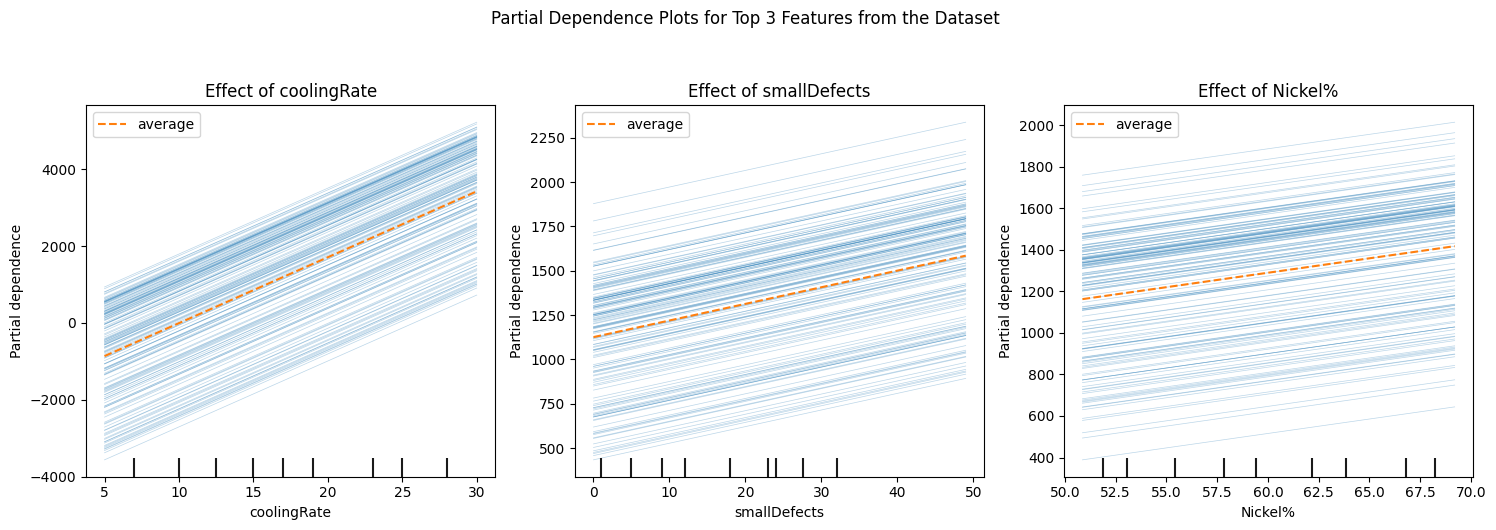

In [759]:
# For Linear Regression
plot_partial_dependence(
    LinRegPipeline, 
    X_test_reg, 
    feature_names, 
    feature_importances
)

In [760]:
# Initialising Random Forest Regressor
RFModel = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Create a pipeline for the Linear Regression model
RFPipeline = create_pipeline(
    RFModel,   # Main model to be pipelined
    'onehot'       # TODO: Change to 'label', 'hybrid', 'onehot' or 'nonploy' for performance comparison
)

# Fit the pipelined model
RFPipeline.fit(
    X_train_reg,    # TODO: Change to 'X_train_reg' or 'X_train_reg_nonpoly' for performance comparison.
    y_train_reg
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quenchTime', 'Nickel%',
                                                   'Iron%', 'Cobalt%',
                                                   'Chromium%', 'largeDefects',
                                                   'forgeTime', 'HeatTreatTime',
                                                   'sliverDefects',
                                                   'coolingRate',
                                                   'coolingRate^{2}',
                                                   'smallDefects',
                                                   'smallDefects^{2}']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['partType', 'microstructure',
                                                   'seedLocation',
                                                   'castType'])],
                                   verbose_feature_names_out=False)),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

Here the parameters such as `n_estimators` and `random_state` are set to default values. The `n_estimators` parameter specifies the number of trees in the forest. The `random_state` parameter is used to set the random seed for reproducibility.

--- Random Forest Model (Training Set) Evaluation Metrics ---
-------------------------------------------------------------
    RMSE: 31.85
    R²  : 0.99
    MAE : 24.73
-------------------------------------------------------------


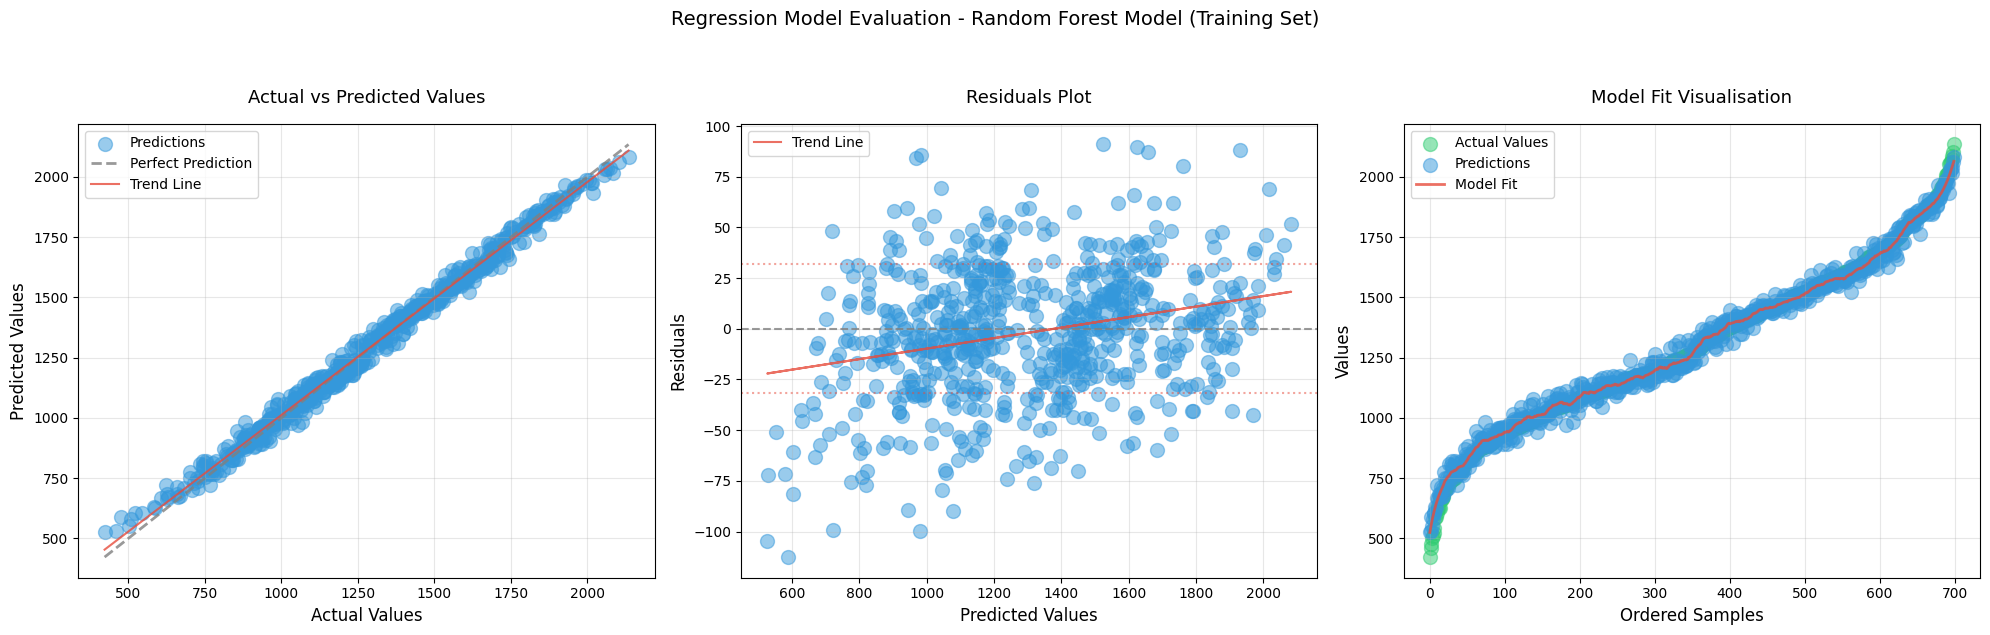

In [761]:
regression_evaluation(
    RFPipeline,
    X_train_reg,
    y_train_reg,
    "Random Forest Model (Training Set)"
)

--- Random Forest Model (Test Set) Evaluation Metrics ---
---------------------------------------------------------
    RMSE: 86.74
    R²  : 0.94
    MAE : 69.62
---------------------------------------------------------


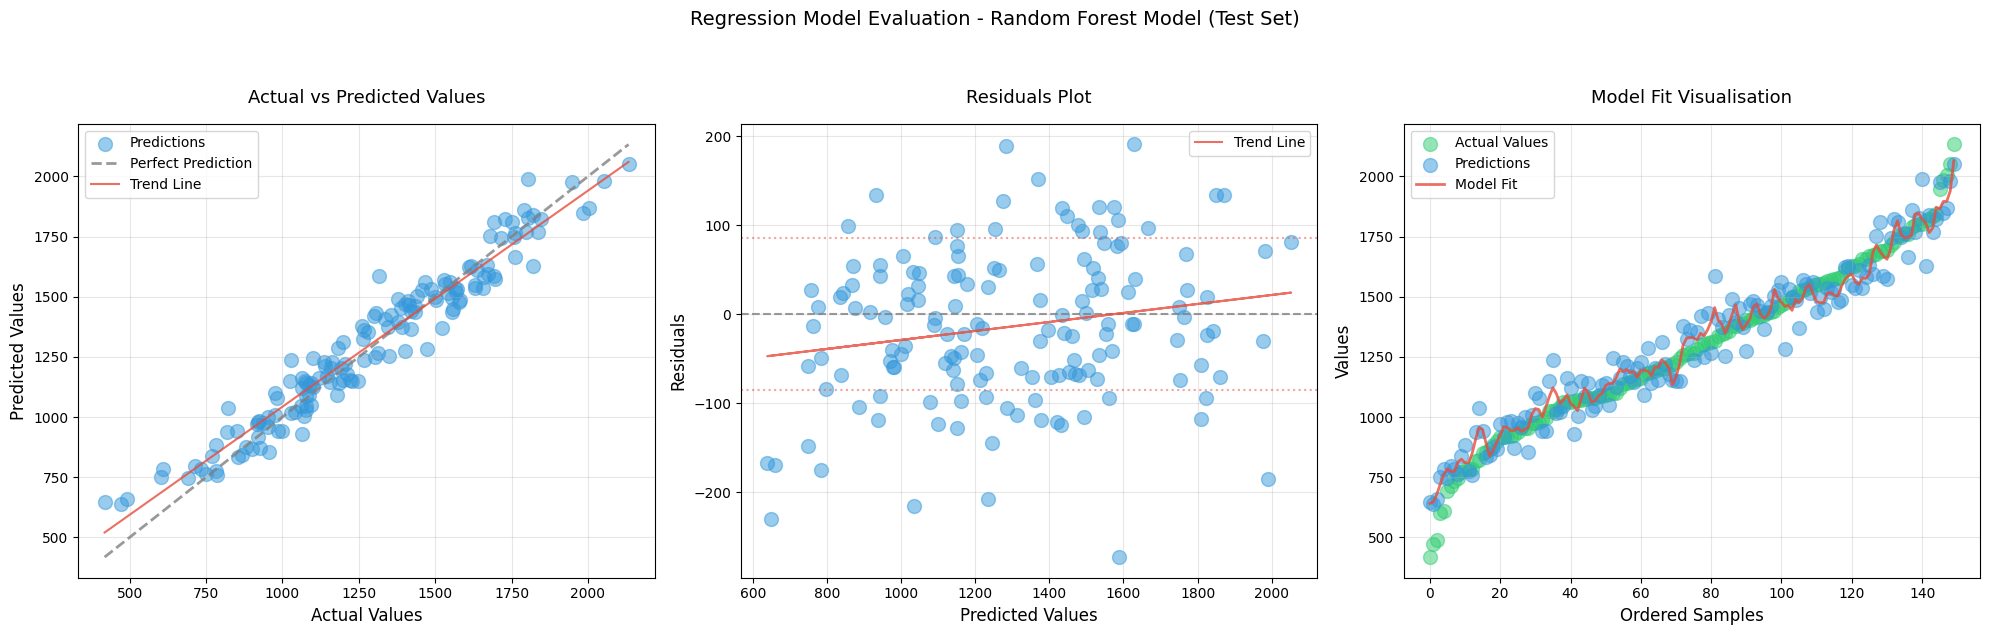

In [762]:
regression_evaluation(
    RFPipeline,
    X_test_reg,
    y_test_reg,
    "Random Forest Model (Test Set)"
)

Here we can see that the accuracy drops because the model was overfitted on training set. Even though the model was overfitted on training set, it is still able to predict the test set with a good accuracy.

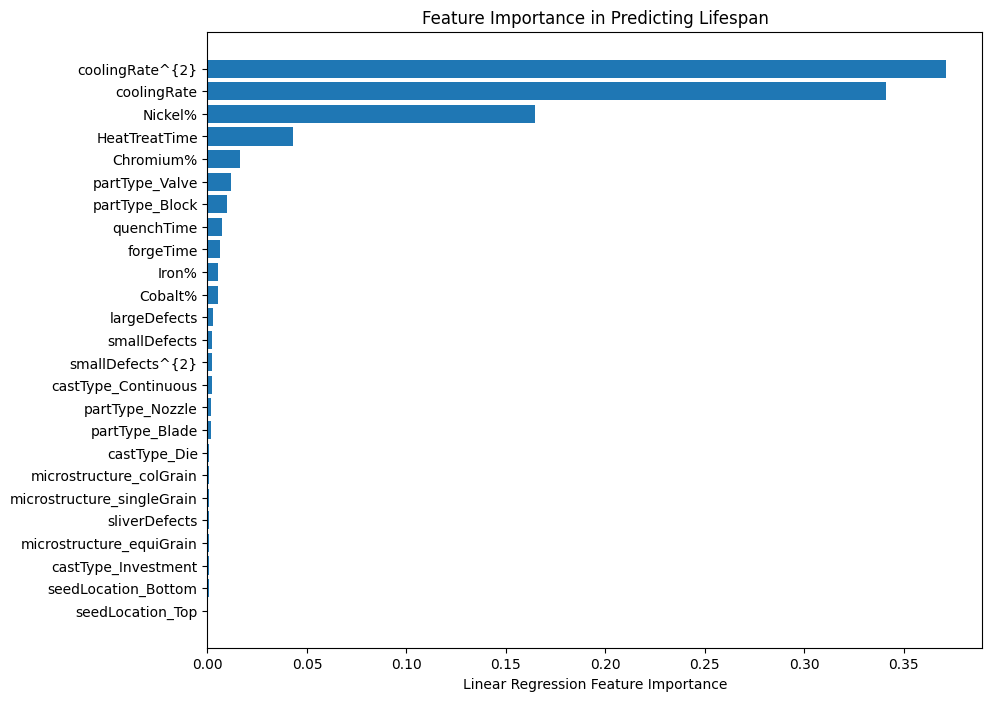

In [763]:
# Feature importance analysis
pipeline_model = RFPipeline
model = pipeline_model.named_steps['model']
feature_importances = model.feature_importances_
feature_names = pipeline_model.named_steps['preprocessor'].get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Linear Regression Feature Importance")
plt.title(f"Feature Importance in Predicting Lifespan")
plt.show()

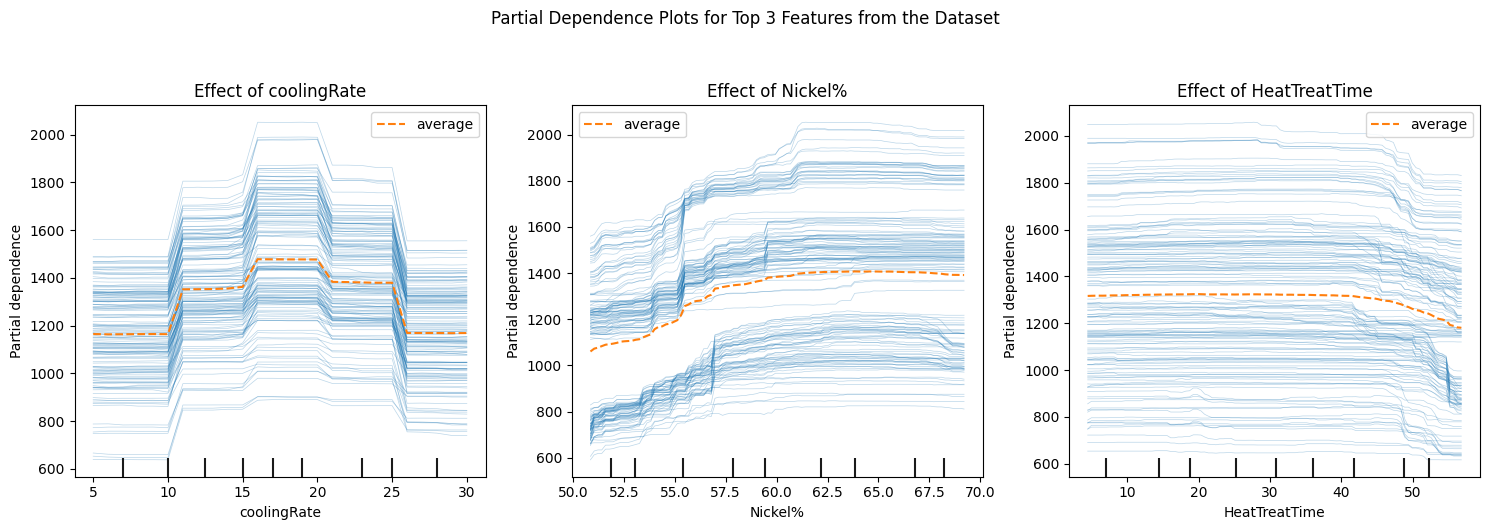

In [764]:
# For Random Forest Regression
plot_partial_dependence(
    RFPipeline, 
    X_test_reg, 
    feature_names, 
    feature_importances
)

In [836]:
# Fit the preprocessor
preprocessor = preprocessor_onehot  # Choose your desired preprocessor
preprocessor.fit(X_train_reg)

# Transform the data
input_train = preprocessor.transform(X_train_reg)
input_test = preprocessor.transform(X_test_reg)
input_val = preprocessor.transform(X_val_reg)

target_train = y_train_reg
target_test = y_test_reg
target_val = y_val_reg

In [837]:
input_dim = input_train.shape[1]

model = tf.keras.Sequential([
    Input(shape=(input_dim,)),
    Dense(units=32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_133 (Dense)               │ (None, 32)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 865 (3.38 KB)

 Trainable params: 865 (3.38 KB)

 Non-trainable params: 0 (0.00 B)

In [849]:
import keras_tuner as kt

# Define the model builder for the tuner
def build_regression_model(hp):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    
    # Tune number of layers
    n_layers = hp.Int('n_layers', min_value=1, max_value=4)
    
    for i in range(n_layers):
        # Tune number of units in each layer
        units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
        model.add(Dense(units=units, activation='relu'))
        
        # Tune whether to use batch normalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(BatchNormalization())
        
        # Tune dropout rate
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Create tuner
tuner = kt.RandomSearch(
    build_regression_model,
    objective='val_loss',
    max_trials=150,
    directory='TuningLogs',
    project_name='Regression-NN'
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Perform hyperparameter search
tuner.search(
    input_train,
    target_train,
    validation_data=(input_val, target_val),
    epochs=100,
    callbacks=[early_stopping]
)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBest Hyperparameters:")
print(f"Number of layers: {best_hp.get('n_layers')}")
for i in range(best_hp.get('n_layers')):
    print(f"\nLayer {i+1}:")
    print(f"Units: {best_hp.get(f'units_{i}')}")
    print(f"Batch Normalization: {best_hp.get(f'batch_norm_{i}')}")
    print(f"Dropout Rate: {best_hp.get(f'dropout_{i}')}")
print(f"\nLearning Rate: {best_hp.get('learning_rate')}")

Trial 150 Complete [00h 00m 10s]
val_loss: 61680.1328125

Best val_loss So Far: 12098.9208984375
Total elapsed time: 00h 22m 15s

Best Hyperparameters:
Number of layers: 2

Layer 1:
Units: 64
Batch Normalization: True
Dropout Rate: 0.1

Layer 2:
Units: 112
Batch Normalization: True
Dropout Rate: 0.2

Learning Rate: 0.005663272327474776


In [862]:
input_dim = input_train.shape[1]

NNModel = tf.keras.Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(112, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.005663272327474776)
NNModel.compile(optimizer=optimizer, loss="mse")

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=10,
    min_lr=1e-5
)

NNModel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 112)            │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112)            │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,761 (38.13 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 352 (1.38 KB)

In [863]:
# Train model with processed data
NNModel.fit(
    x=input_train, 
    y=target_train,
    validation_data=(input_val, target_val.values),
    epochs=450,
    batch_size=38,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, min_lr=1e-5)
    ],
    verbose=1
)

Epoch 1/450
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1760366.6250 - val_loss: 1785094.1250 - learning_rate: 0.0057
Epoch 2/450
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1749940.6250 - val_loss: 1779229.8750 - learning_rate: 0.0057
Epoch 3/450
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1725678.7500 - val_loss: 1768292.0000 - learning_rate: 0.0057
Epoch 4/450
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1683565.5000 - val_loss: 1762611.8750 - learning_rate: 0.0057
Epoch 5/450
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1622233.3750 - val_loss: 1796767.3750 - learning_rate: 0.0057
Epoch 6/450
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1548141.8750 - val_loss: 1797561.8750 - learning_rate: 0.0057
Epoch 7/450
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1462007.1250 - val_loss: 1812795.7500 - learning_rate: 0.0057
Epoch 8/450
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1362190.8750 - val_loss: 1793907.2500 - learning_rate: 0.0057
Epoch 9/450
19/19 ━━━━━━━━━━━━━━

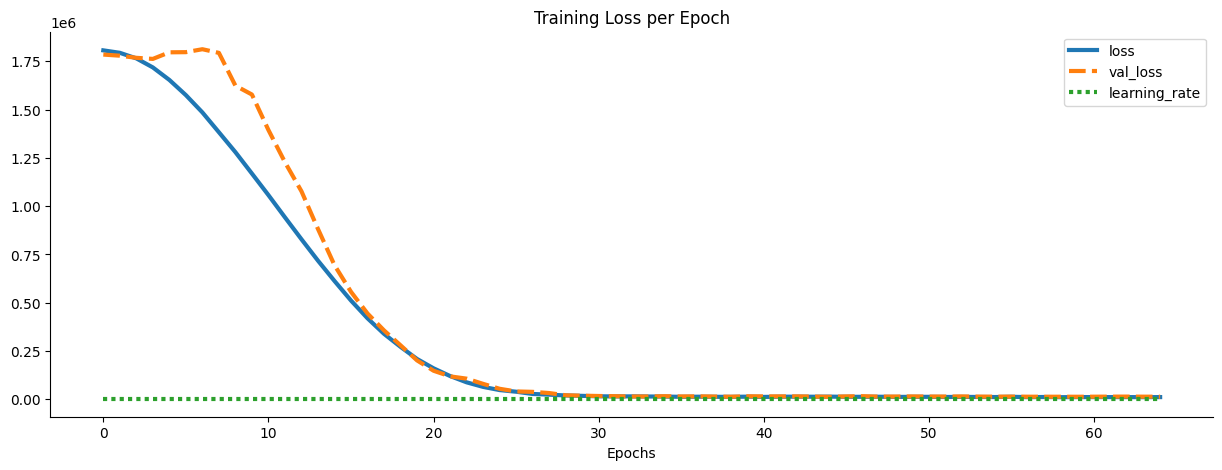

In [864]:
losses = pd.DataFrame(NNModel.history.history)

plt.figure(figsize=(15,5))
sns.lineplot(data=losses,lw=3)
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training Loss per Epoch')
sns.despine()
plt.show()

In [865]:
# 1. Modify the wrapper class
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Set a fitted attribute
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

# 2. Prepare the processed data with feature names
X_test_processed_df = pd.DataFrame(X_test_reg, columns=totalnum_features)

# 3. Wrap the model
NNWrapped = KerasRegressorWrapper(NNModel)

# Create a pipeline for the Neural Network Wrapper model
NNPipeline = create_pipeline(
    NNWrapped,     # Main model to be pipelined
    'onehot'       # TODO: Change to 'label', 'hybrid', 'onehot' or 'nonploy' for performance comparison
)

# 4. Fit the wrapper (even though the model is already trained)
NNPipeline.fit(
    X_test_reg,
    y_train_reg
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quenchTime', 'Nickel%',
                                                   'Iron%', 'Cobalt%',
                                                   'Chromium%', 'largeDefects',
                                                   'forgeTime', 'HeatTreatTime',
                                                   'sliverDefects',
                                                   'coolingRate',
                                                   'coolingRate^{2}',
                                                   'smallDefects',
                                                   'smallDefects^{2}']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['partType', 'microstructure',
                                                   'seedLocation',
                                                   'castType'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 KerasRegressorWrapper(model=<Sequential name=sequential_3, built=True>))])

Raw predictions shape        : (700, 1)
Flattened predictions shape  : (700,)
Target shape                 : (700,)

--- Neural Network Model (Training Set) Evaluation Metrics ---
--------------------------------------------------------------
    RMSE: 71.32
    R²  : 0.96
    MAE : 56.58
--------------------------------------------------------------


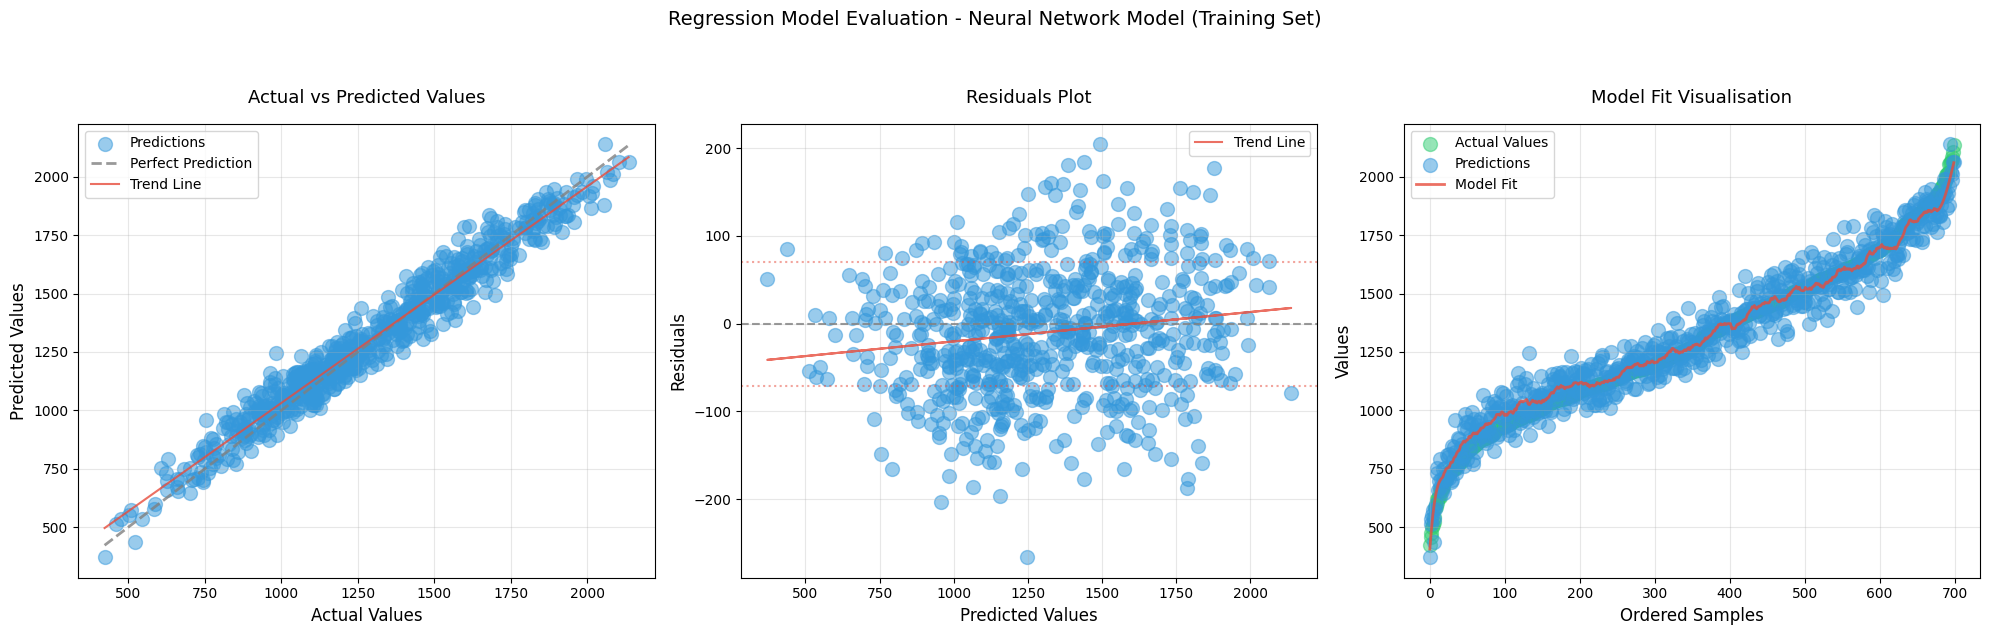

In [866]:
regression_evaluation(
    NNModel,
    input_train,
    target_train,
    "Neural Network Model (Training Set)"
)

--- Neural Network Model (Test Set) Using Wrapper Class Evaluation Metrics ---
------------------------------------------------------------------------------
    RMSE: 113.29
    R²  : 0.90
    MAE : 90.19
------------------------------------------------------------------------------


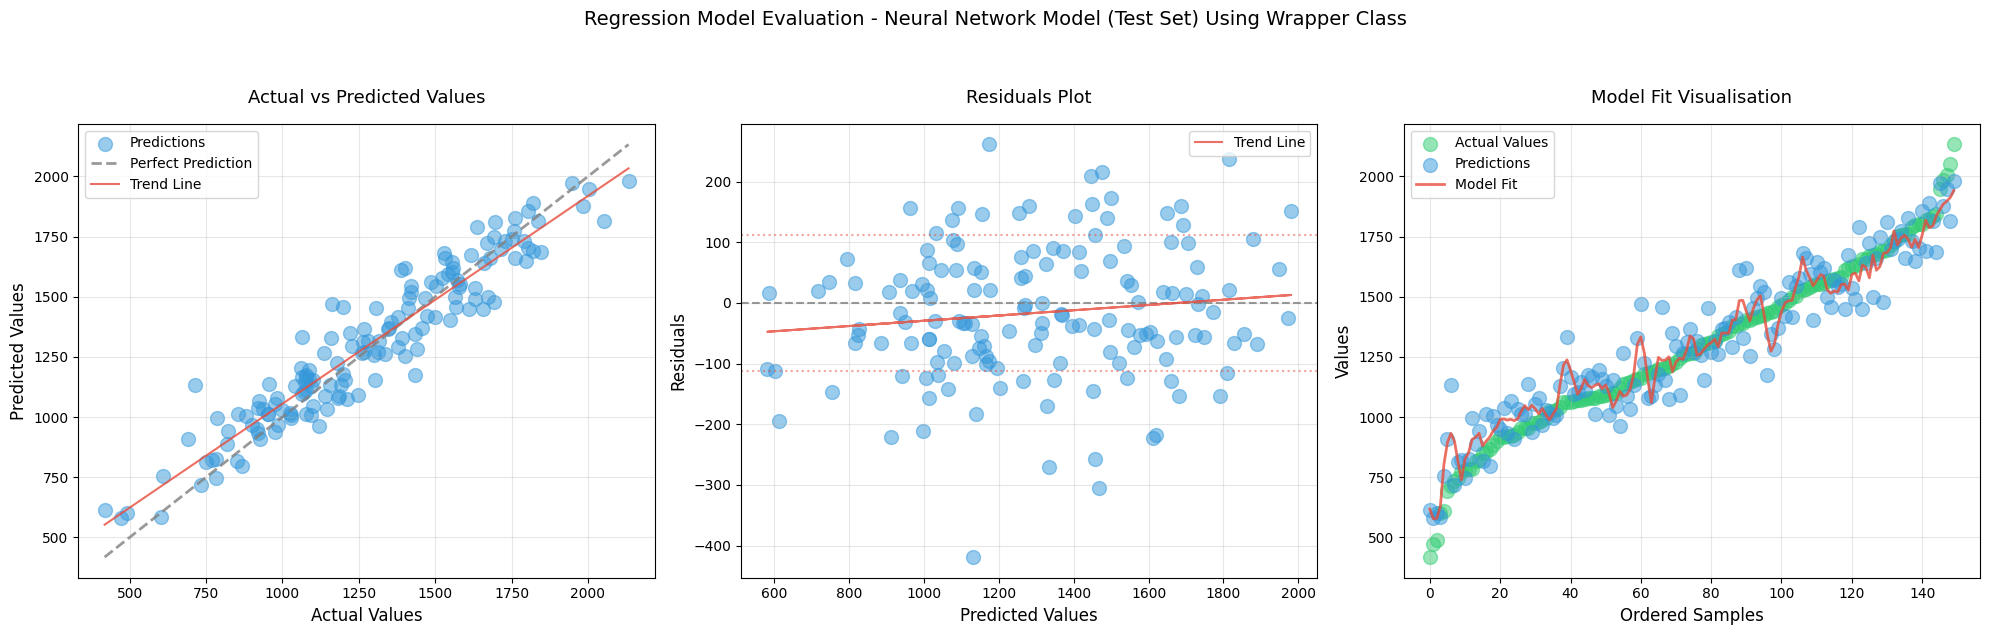

In [867]:
regression_evaluation(
    NNPipeline,
    X_test_reg,
    y_test_reg,
    "Neural Network Model (Test Set) Using Wrapper Class"
)

# TODO: As this project also have preprocessed the data using pipeline,
# we can directly pass those data to the model.
# regression_evaluation(
#     NNModel,
#     input_test,
#     target_test,
#     "Neural Network Model (Test Set)"
# )

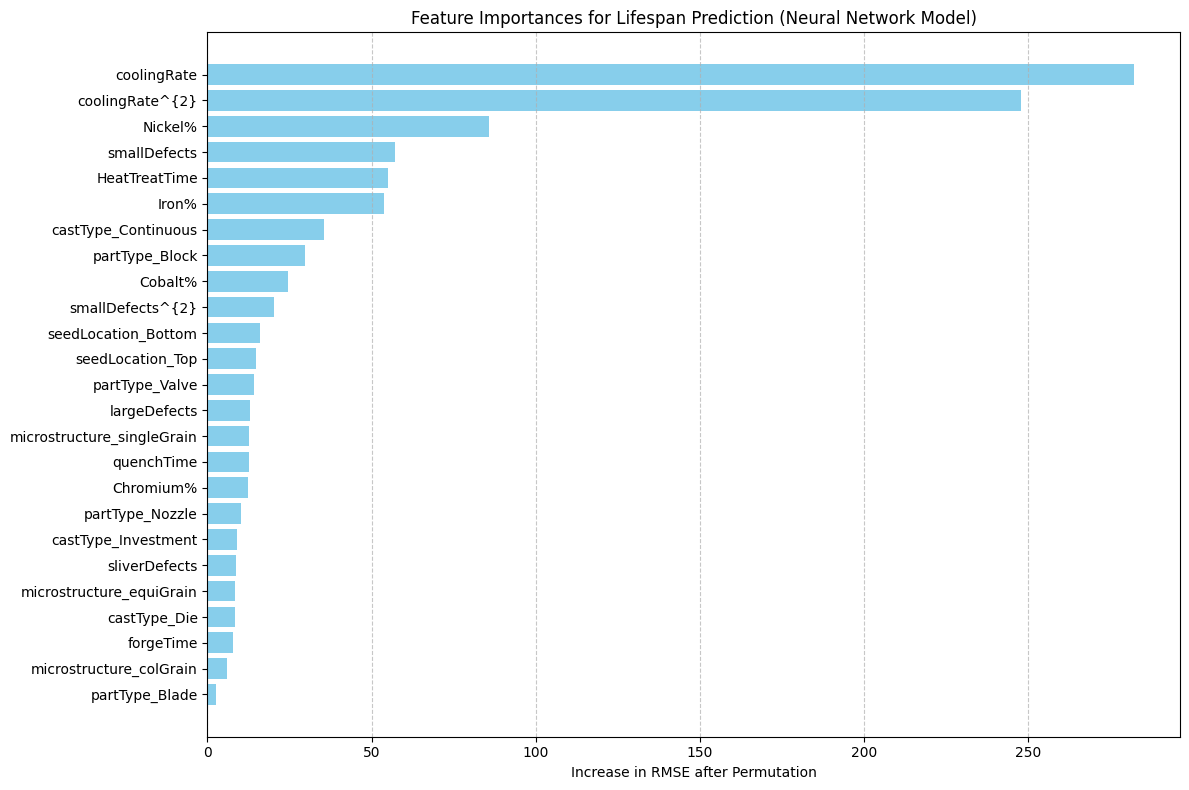

In [868]:
# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Baseline performance on the training set
predictions = NNModel.predict(input_train, verbose=0)
baseline_rmse = root_mean_squared_error(target_train, predictions)

# Initialize list to store importance scores
feature_importances = []

# Number of times to permute each feature
num_repeats = 5

# Loop over all features to compute importance
for i in range(input_train.shape[1]):
    importance_scores = []
    for _ in range(num_repeats):
        # Copy the original data to avoid modifying it
        input_permuted = input_train.copy()
        # Shuffle the values of the current feature
        np.random.shuffle(input_permuted[:, i])
        # Predict with the permuted data
        predictions_permuted = NNModel.predict(input_permuted, verbose=0)
        # Calculate new RMSE
        permuted_rmse = root_mean_squared_error(target_train, predictions_permuted)
        # Importance is the increase in RMSE
        importance = permuted_rmse - baseline_rmse
        importance_scores.append(importance)
    # Average importance over the repeats
    feature_importances.append(np.mean(importance_scores))

# Create a DataFrame to hold feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort features by importance in descending order
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Increase in RMSE after Permutation')
plt.title('Feature Importances for Lifespan Prediction (Neural Network Model)')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

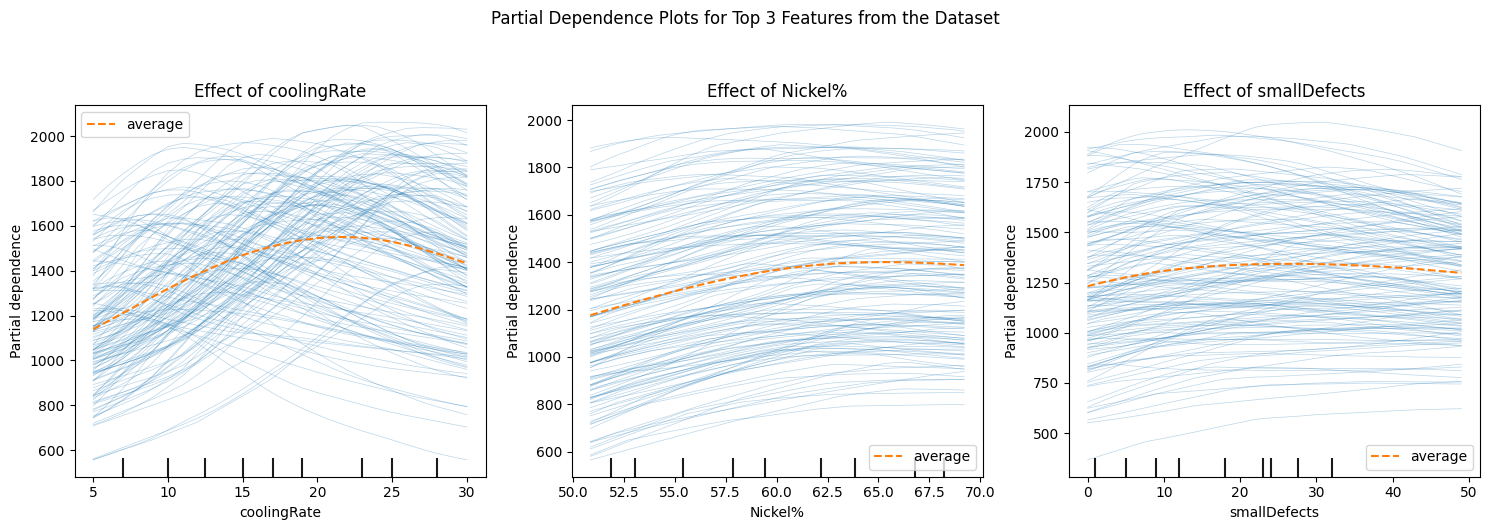

In [869]:
plot_partial_dependence(
    NNPipeline, 
    X_test_reg, 
    feature_names, 
    feature_importances
)

# Classification Implementation

In [775]:
# Utility function for creating Lifetime labels based on lifespan distribution using K-Means Clustering
def create_labels(df, threshold_value=1500):
    # TODO: Add silhouette score
    df['Lifetime'] = np.where(df['Lifespan'] < threshold_value, 'Unacceptable', None)
    acceptable_df = df[df['Lifespan'] >= threshold_value].copy()

    # K-Means Clustering to create labels beyond 'Unacceptable'
    if len(acceptable_df) > 1:
        X_acceptable = acceptable_df[['Lifespan']]
        max_k = min(10, len(acceptable_df))
        k_values = range(1, max_k)

        # Finding the optimal number of clusters
        inertia = [KMeans(n_clusters=k, random_state=random_state).fit(X_acceptable).inertia_ for k in k_values]
        kneedle = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
        elbow_k = kneedle.elbow if kneedle.elbow is not None else 2

        kmeans = KMeans(n_clusters=elbow_k, random_state=random_state)
        acceptable_df['cluster'] = kmeans.fit_predict(X_acceptable)
        
        # Create labels based on clustering
        cluster_means = acceptable_df.groupby('cluster')['Lifespan'].mean()
        cluster_order = cluster_means.sort_values().index.tolist()
        desired_labels = ['Fair', 'Good', 'Excellent']
        
        # Assign appropriate labels
        labels = {cluster_order[i]: desired_labels[i] if i < len(desired_labels) else f'Cluster-{i}' for i in range(elbow_k)}
        acceptable_df['Lifetime'] = acceptable_df['cluster'].map(labels)

        # Update main dataframe
        df.loc[acceptable_df.index, 'Lifetime'] = acceptable_df['Lifetime']
        df.drop(columns=['cluster'], errors='ignore', inplace=True)

        # Cell 6: Plot the Elbow Method
        plt.figure(figsize=(10, 6))
        # Plot line segments with different colors
        plt.plot(k_values[:elbow_k], inertia[:elbow_k], 'bo-', label="Decreasing Phase")
        plt.plot(k_values[elbow_k - 1:], inertia[elbow_k - 1:], 'go-', label="Slow Decrease Phase")

        # Vertical line at elbow
        plt.axvline(x=elbow_k, linestyle='--', color='r', label=f'Optimal $k$ = {elbow_k}')

        # Highlight the elbow point with a red marker and annotation
        plt.plot(elbow_k, inertia[elbow_k - 1], 'ro')  # red point at elbow
        plt.annotate(f"Optimal $k$ = {elbow_k}", xy=(elbow_k, inertia[elbow_k - 1]),
                    xytext=(elbow_k + 1, inertia[elbow_k - 1] + 0.2e7),
                    arrowprops=dict(facecolor='black', arrowstyle="->"))

        # Annotate each segment with inertia differences
        for i in range(1, len(k_values)):
            plt.annotate(f"{inertia[i-1] - inertia[i]:.2e}",
                        (k_values[i] - 0.5, (inertia[i-1] + inertia[i]) / 2),
                        fontsize=8, color='gray')

        # Set plot labels and title
        plt.xlabel(f'Number of Clusters ($k$)')
        plt.ylabel('Inertia')
        plt.title(f'Elbow Method for Optimal $k$')
        plt.grid(color='grey', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

    else:
        print("Not enough data to perform clustering on acceptable parts.")
    return df

In [776]:
# Creating a new dataframe with the transformed ploynomial features for classification
clf_df = df_transformed.copy()

# Extracting the numerical, categorical and polynomial features from the dataframe
categorical_features, totalnum_features, polynomial_features, numerical_features = extract_features(clf_df, target='Lifespan')

Target feature: Lifespan

Categorical features: 4
- partType
- microstructure
- seedLocation
- castType

Numerical features: 11
- quenchTime
- Nickel%
- Iron%
- Cobalt%
- Chromium%
- largeDefects
- forgeTime
- HeatTreatTime
- sliverDefects
- coolingRate
- smallDefects

Polynomial features: 2
- coolingRate^{2}
- smallDefects^{2}

Total numerical features: 13


quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects  Lifespan  \
0        3.84    65.73  16.52    16.82       0.93             0   1469.17   
1        2.62    54.22  35.38     6.14       4.26             0   1793.64   
2        0.76    51.83  35.95     8.81       3.41             3    700.60   
3        2.01    57.03  23.33    16.86       2.78             1   1082.10   
4        4.13    59.62  27.37    11.45       1.56             0   1838.83   

  partType microstructure  forgeTime  HeatTreatTime  sliverDefects  \
0   Nozzle      equiGrain       6.47          46.87              0   
1    Block    singleGrain       3.48          44.70              0   
2    Blade      equiGrain       1.34           9.54              0   
3   Nozzle       colGrain       2.19          20.29              0   
4    Blade       colGrain       3.87          16.13              0   

  seedLocation    castType  coolingRate  coolingRate^{2}  smallDefects  \
0       Bottom         Die         13.0            169.0          10.0   
1       Bottom  Investment         19.0            361.0          19.0   
2       Bottom  Investment         28.0            784.0          35.0   
3          Top  Continuous          9.0             81.0           0.0   
4          Top         Die         16.0            256.0          10.0   

   smallDefects^{2}  
0             100.0  
1             361.0  
2            1225.0  
3               0.0  
4             100.0

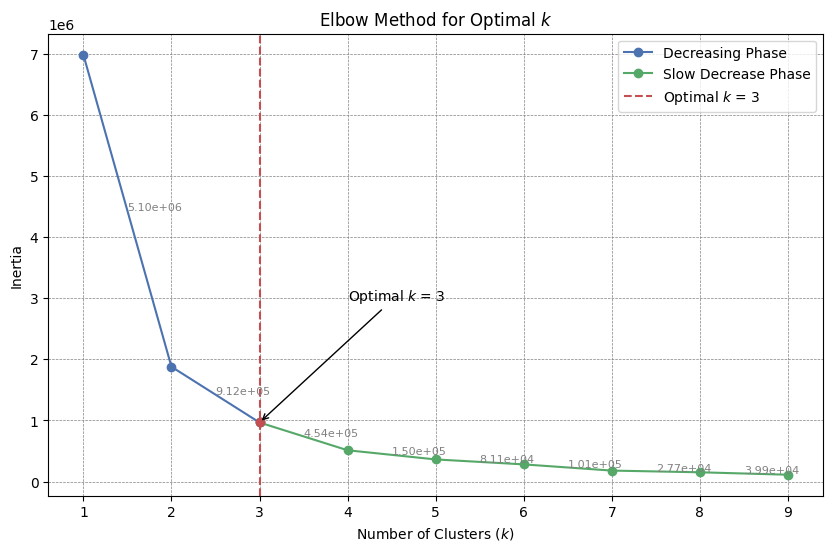

In [777]:
# Feature Engineering - Create Lifetime Labels
clf_df = create_labels(clf_df)

In [778]:
# View the loaded data
clf_df.head()

quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects  Lifespan  \
0        3.84    65.73  16.52    16.82       0.93             0   1469.17   
1        2.62    54.22  35.38     6.14       4.26             0   1793.64   
2        0.76    51.83  35.95     8.81       3.41             3    700.60   
3        2.01    57.03  23.33    16.86       2.78             1   1082.10   
4        4.13    59.62  27.37    11.45       1.56             0   1838.83   

  partType microstructure  forgeTime  HeatTreatTime  sliverDefects  \
0   Nozzle      equiGrain       6.47          46.87              0   
1    Block    singleGrain       3.48          44.70              0   
2    Blade      equiGrain       1.34           9.54              0   
3   Nozzle       colGrain       2.19          20.29              0   
4    Blade       colGrain       3.87          16.13              0   

  seedLocation    castType  coolingRate  coolingRate^{2}  smallDefects  \
0       Bottom         Die         13.0            169.0          10.0   
1       Bottom  Investment         19.0            361.0          19.0   
2       Bottom  Investment         28.0            784.0          35.0   
3          Top  Continuous          9.0             81.0           0.0   
4          Top         Die         16.0            256.0          10.0   

   smallDefects^{2}      Lifetime  
0             100.0  Unacceptable  
1             361.0          Good  
2            1225.0  Unacceptable  
3               0.0  Unacceptable  
4             100.0          Good

In [779]:
# Display the cluster ranges
# Group the data by 'Lifetime' and aggregate to find the min and max Lifespan for each group
cluster_ranges = clf_df.groupby('Lifetime')['Lifespan'].agg(['min', 'max']).sort_values(by='min').reset_index()
# Display the sorted DataFrame
display(cluster_ranges)

Lifetime      min      max
0  Unacceptable   417.99  1499.31
1          Fair  1501.76  1661.54
2          Good  1666.64  1850.75
3     Excellent  1854.50  2134.53

In [780]:
unique_lifespan_count = clf_df['Lifespan'].nunique()
print(f"Number of unique values in 'Lifespan' column: {unique_lifespan_count}")

# Find the unique values that occur more than once in the 'Lifespan' column
print("\nDuplicate values:")
duplicate_values = clf_df['Lifespan'].value_counts()
duplicate_values = duplicate_values[duplicate_values > 1]

# Output the unique values and their counts
print(duplicate_values)

Number of unique values in 'Lifespan' column: 998

Duplicate values:
Lifespan
1262.14    2
932.69     2
Name: count, dtype: int64


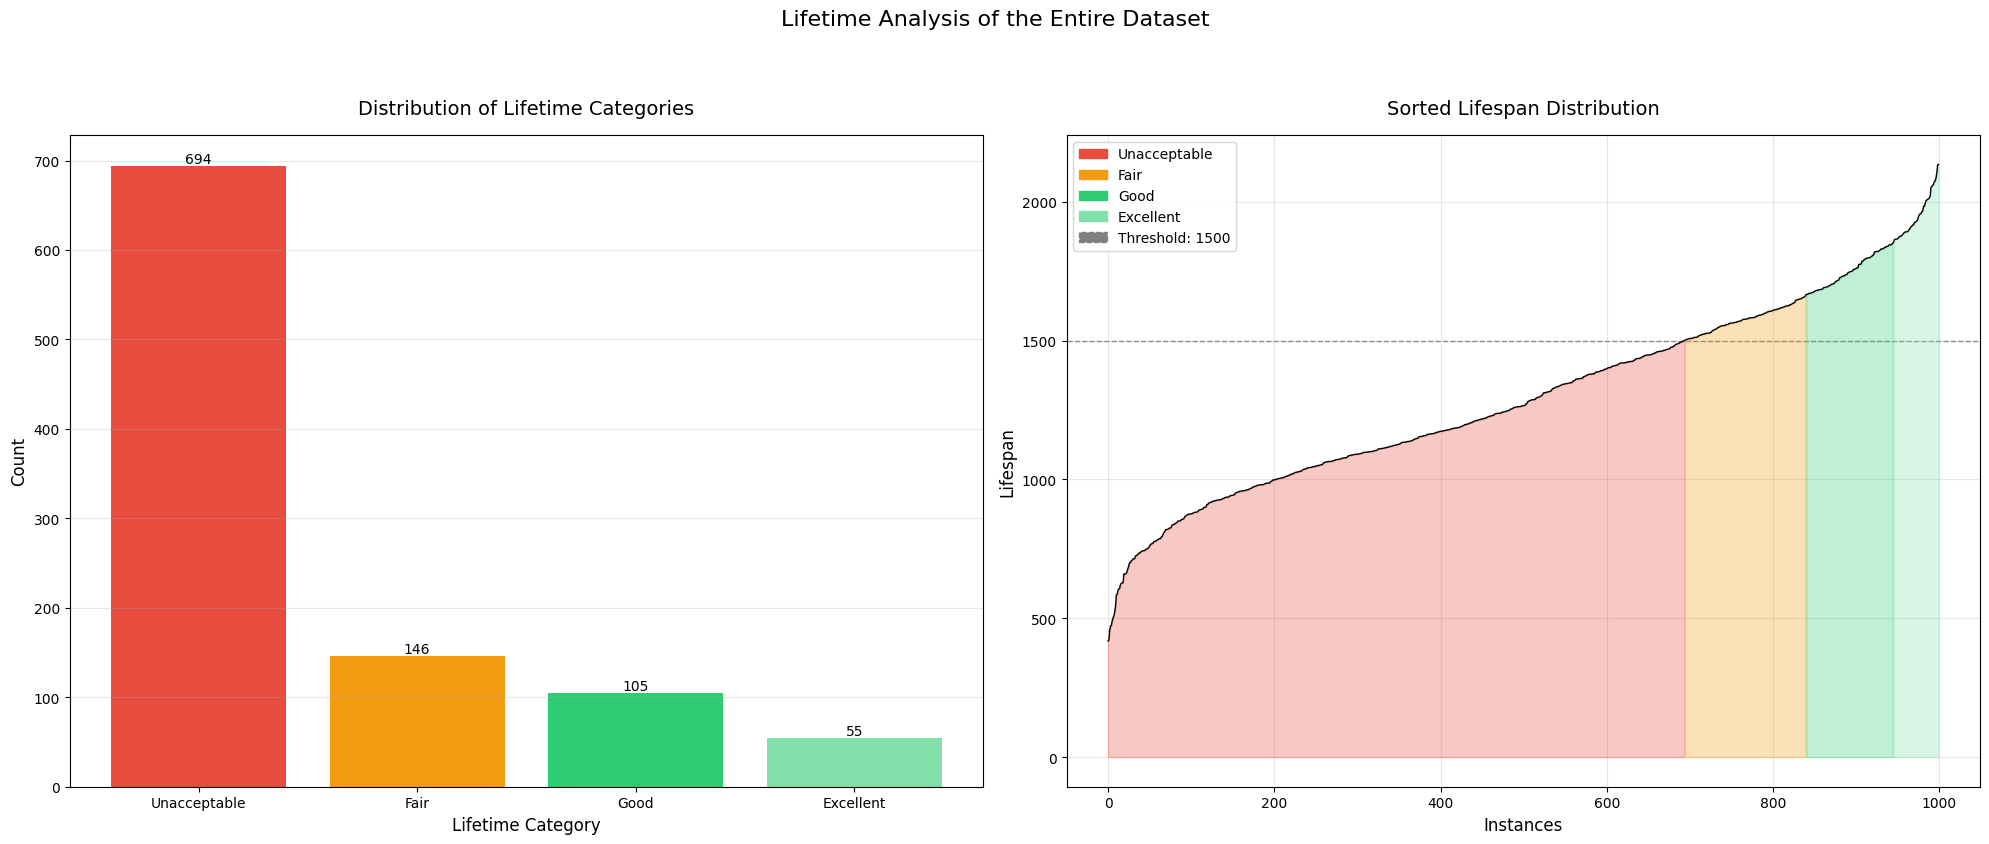

In [781]:
def lifetime_analysis(df, message='Entire Dataset'):
    # Set style
    plt.style.use('default')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Lifetime Analysis of the {message}', fontsize=16, y=1.05)
    
    # Color palette
    colors = {
        'Unacceptable': '#E74C3C',  # Red
        'Fair': '#F39C12',          # Orange
        'Good': '#2ECC71',          # Green
        'Excellent': '#82E0AA'      # Light Green
    }
    
    # Plot 1: Distribution
    counts = df['Lifetime'].value_counts().reindex(cluster_ranges['Lifetime'].unique())
    bars = ax1.bar(range(len(counts)), counts, color=[colors[cat] for cat in counts.index])
    
    # Customize first plot
    ax1.set_xticks(range(len(counts)))
    ax1.set_xticklabels(counts.index, rotation=0)
    ax1.set_xlabel('Lifetime Category', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Distribution of Lifetime Categories', fontsize=14, pad=15)
    ax1.grid(True, axis='y', alpha=0.3)
    
    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    # Plot 2: Sorted Lifespan
    df_sorted = df.sort_values('Lifespan').reset_index(drop=True)
    x = df_sorted.index
    y = df_sorted['Lifespan']
    categories = df_sorted['Lifetime']
    
    # Plot the main line
    ax2.plot(x, y, color='black', linewidth=1, zorder=3)
    
    # Fill areas by category
    for key, group in groupby(zip(x, y, categories), lambda t: t[2]):
        group = list(group)
        x_vals = [item[0] for item in group]
        y_vals = [item[1] for item in group]
        ax2.fill_between(x_vals, y_vals, color=colors[key], alpha=0.3, zorder=2)
    
    # Add threshold line
    ax2.axhline(y=1500, color='gray', linestyle='--', linewidth=1, zorder=1, 
                label='Threshold: 1500')
    
    # Customize second plot
    ax2.set_xlabel('Instances', fontsize=12)
    ax2.set_ylabel('Lifespan', fontsize=12)
    ax2.set_title('Sorted Lifespan Distribution', fontsize=14, pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Create legend
    handles = [mpatches.Patch(color=colors[cat], label=cat) for cat in colors.keys()]
    handles.append(mpatches.Patch(color='gray', linestyle='--', label='Threshold: 1500'))
    ax2.legend(handles=handles, loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function
lifetime_analysis(clf_df)

In [782]:
# Bin 'Lifespan' into quartiles
clf_df['Lifespan_bin'] = pd.qcut(clf_df['Lifespan'], q=4, duplicates='drop')

# Create a combined stratification label
clf_df['Stratify_Label'] = clf_df['Lifetime'] + '_' + clf_df['Lifespan_bin'].astype(str)

# First, split into training and temp (validation + test)
clf_train_df, temp_df = train_test_split(
    clf_df,
    test_size=0.3,
    stratify=clf_df['Stratify_Label'],
    random_state=random_state
)

# Then, split temp_df equally into validation and test sets
clf_val_df, clf_test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['Stratify_Label'],
    random_state=random_state
)

# Remove the temporary DataFrame
del temp_df

# Optionally, drop the temporary columns
clf_train_df = clf_train_df.drop(columns=['Lifespan_bin', 'Stratify_Label'])
clf_val_df = clf_val_df.drop(columns=['Lifespan_bin', 'Stratify_Label'])
clf_test_df = clf_test_df.drop(columns=['Lifespan_bin', 'Stratify_Label'])

train_shape, val_shape, test_shape = clf_train_df.shape, clf_val_df.shape, clf_test_df.shape
print(f"Training set shape   : {train_shape}")
print(f"Validation set shape : {val_shape}")
print(f"Test set shape       : {test_shape}")

Training set shape   : (700, 19)
Validation set shape : (150, 19)
Test set shape       : (150, 19)


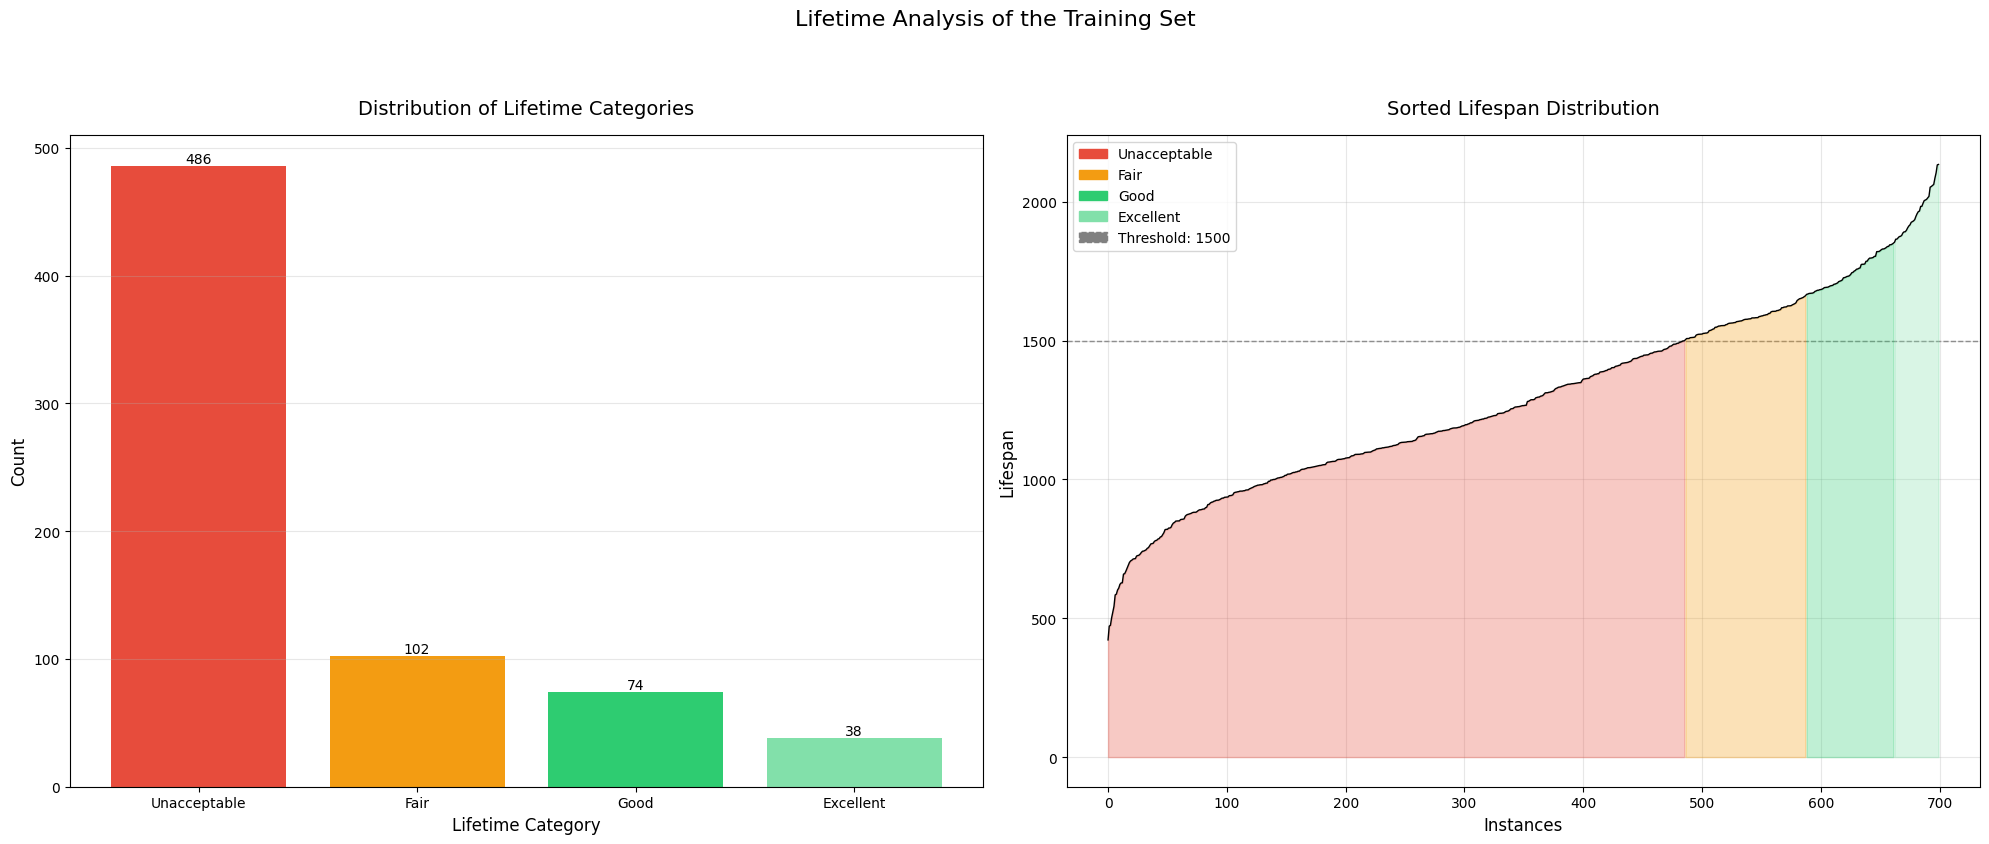

In [783]:
lifetime_analysis(clf_train_df, message='Training Set')

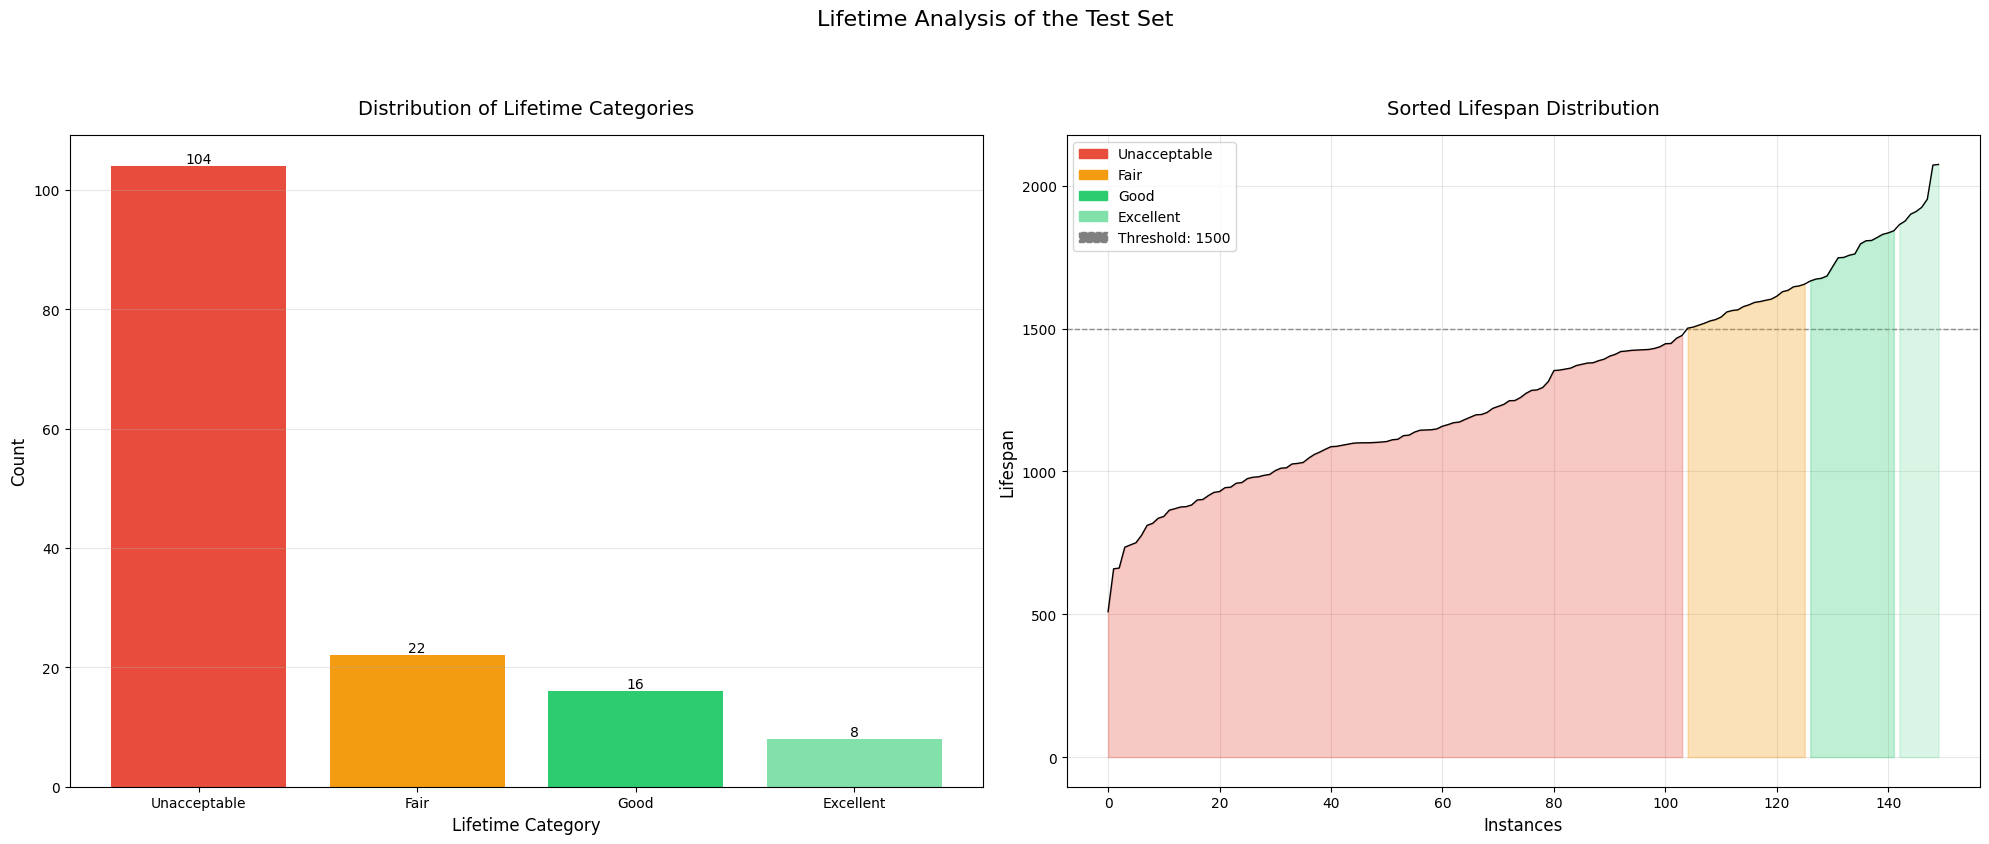

In [784]:
lifetime_analysis(clf_test_df, message='Test Set')

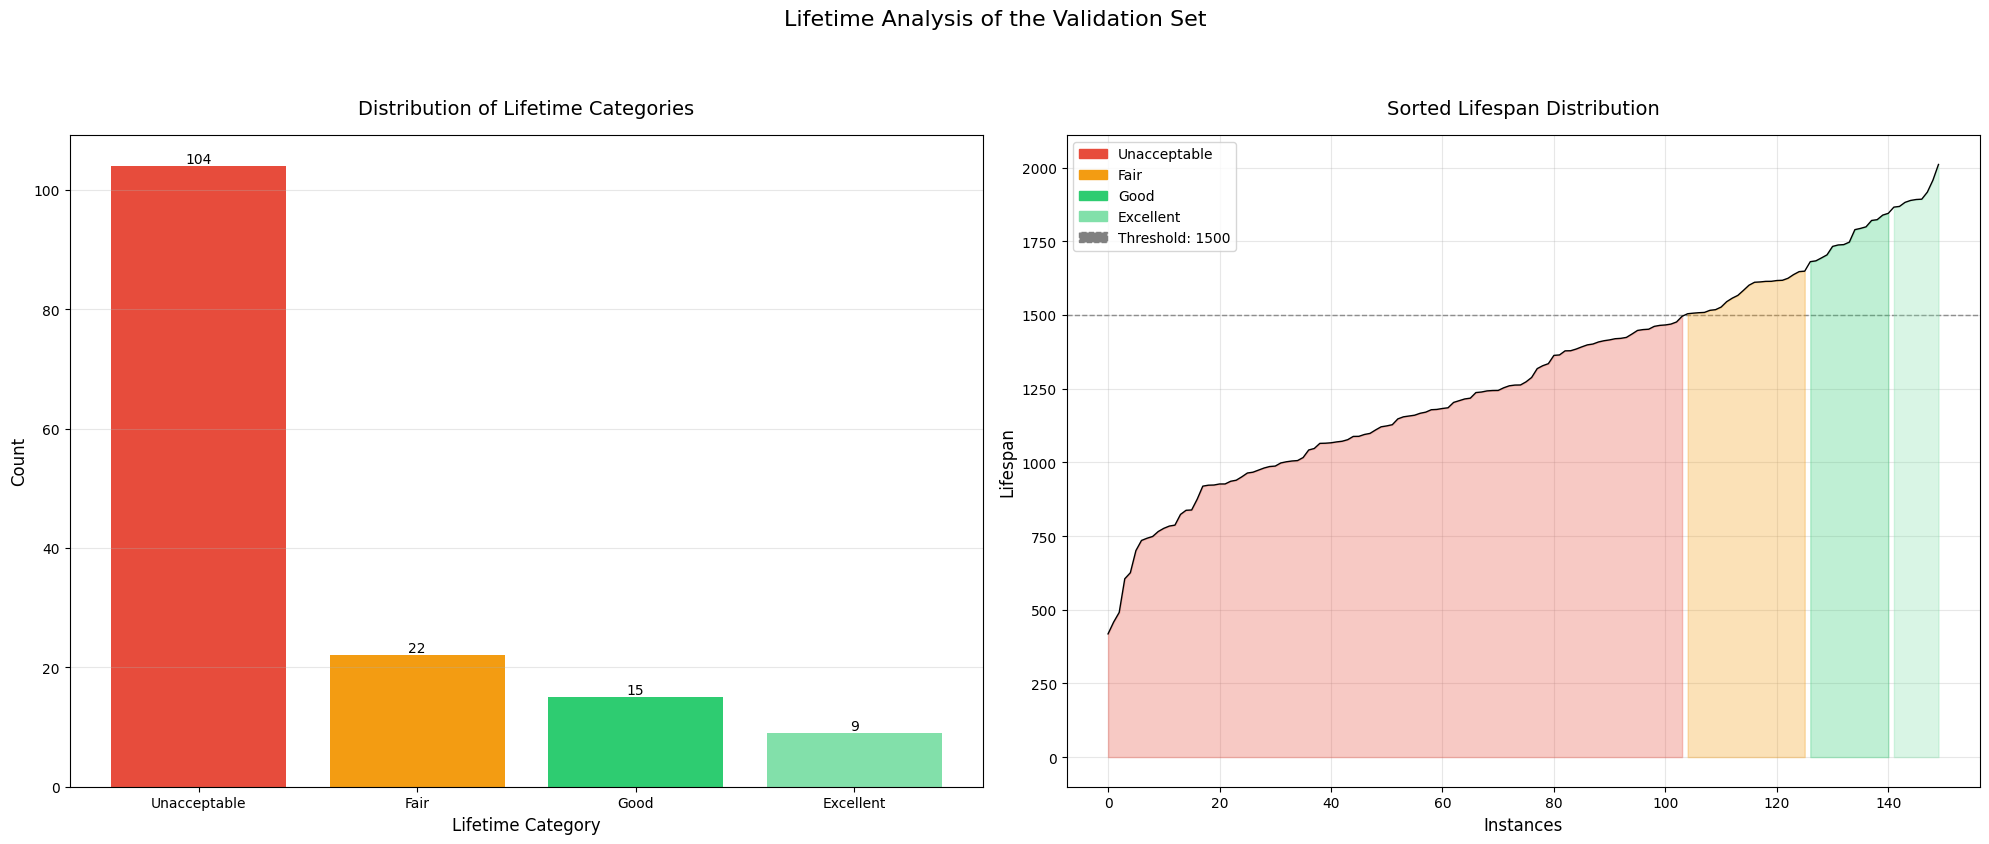

In [785]:
lifetime_analysis(clf_val_df, message='Validation Set')

In [786]:
target = 'Lifespan'

clf_train_df = clf_train_df.drop(columns=[target])
clf_val_df = clf_val_df.drop(columns=[target])
clf_test_df = clf_test_df.drop(columns=[target])

# Removing the target column from the split sets.
train_shape, val_shape, test_shape = clf_train_df.shape, clf_val_df.shape, clf_test_df.shape
print(f"After removing the {target} column:")
print(f"Training set shape   : {train_shape}")
print(f"Validation set shape : {val_shape}")
print(f"Test set shape       : {test_shape}")
display(clf_train_df.head())

After removing the Lifespan column:
Training set shape   : (700, 18)
Validation set shape : (150, 18)
Test set shape       : (150, 18)


quenchTime  Nickel%  Iron%  Cobalt%  Chromium%  largeDefects partType  \
786        3.77    55.62  24.14    15.85       4.39             0    Blade   
312        2.60    54.28  23.23    18.91       3.58             4   Nozzle   
891        4.42    62.23  27.81     5.64       4.32             0   Nozzle   
900        3.64    56.11  31.42    10.32       2.15             0    Block   
692        3.01    68.73  13.03    16.69       1.55             0   Nozzle   

    microstructure  forgeTime  HeatTreatTime  sliverDefects seedLocation  \
786       colGrain       4.73          48.35              0          Top   
312       colGrain       5.18           4.47              0          Top   
891      equiGrain       4.73          32.30              0       Bottom   
900    singleGrain       4.36           3.10              0       Bottom   
692       colGrain       2.42          20.00              0          Top   

       castType  coolingRate  coolingRate^{2}  smallDefects  smallDefects^{2}  \
786  Investment         19.0            361.0          12.0             144.0   
312         Die         23.0            529.0          27.0             729.0   
891  Continuous         14.0            196.0          10.0             100.0   
900  Continuous         13.0            169.0           7.0              49.0   
692  Investment         29.0            841.0          36.0            1296.0   

         Lifetime  
786          Good  
312  Unacceptable  
891          Good  
900          Fair  
692  Unacceptable

In [ ]:
# Setting target variable
target = 'Lifetime'

# Features (X) and target (y)
X_train_clf = clf_train_df.drop(columns=[target])   # Features excluding the target variable
y_train_clf = clf_train_df[target]                  # Target variable

# Features (X) and target (y)
X_test_clf = clf_test_df.drop(columns=[target])     # Features excluding the target variable
y_test_clf = clf_test_df[target]                    # Target variable

# Features (X) and target (y)
X_val_clf = clf_val_df.drop(columns=[target])       # Features excluding the target variable
y_val_clf = clf_val_df[target]                      # Target variable

# Saving the dataset without polynomial features for testing the results
nonpoly_columns = [col for col in X_train_clf.columns if col not in polynomial_features]

X_train_clf_nonpoly = X_train_clf[nonpoly_columns]
X_test_clf_nonpoly = X_test_clf[nonpoly_columns]
X_val_clf_nonpoly = X_val_clf[nonpoly_columns]

In [788]:
# Define the model
LogRegModel = LogisticRegression(max_iter=1000, random_state=random_state)

In [791]:
LogRegPipeline = create_pipeline(
    LogRegModel,   # Main model to be pipelined
    'onehot'       # TODO: Change to 'label', 'hybrid', 'onehot' or 'nonploy' for performance comparison
)

LogRegPipeline.fit(
    X_train_clf,
    y_train_clf
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quenchTime', 'Nickel%',
                                                   'Iron%', 'Cobalt%',
                                                   'Chromium%', 'largeDefects',
                                                   'forgeTime', 'HeatTreatTime',
                                                   'sliverDefects',
                                                   'coolingRate',
                                                   'coolingRate^{2}',
                                                   'smallDefects',
                                                   'smallDefects^{2}']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['partType', 'microstructure',
                                                   'seedLocation',
                                                   'castType'])],
                                   verbose_feature_names_out=False)),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [792]:
def classification_evaluation(model, X, y, message="Model", scale=False):
    if scale:
        scaler = StandardScaler()
        X = pd.DataFrame(
            scaler.fit_transform(X),
            columns=X.columns,
            index=X.index
        )

    # Get predictions and probabilities
    if isinstance(model, tf.keras.Model):
        y_pred_probs = model.predict(X, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred = model.predict(X)
        y_pred_probs = model.predict_proba(X)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1_weighted = f1_score(y, y_pred, average='weighted')
    
    # Calculate recall specifically for "Unacceptable" class
    unacceptable_recall = recall_score(y, y_pred, 
                                     labels=['Unacceptable'], 
                                     average=None)[0]

    # Calculate per-class precision
    precisions = precision_score(y, y_pred, 
                               labels=np.unique(y), 
                               average=None)
    
    # Print metrics
    title = f"--- {message} Evaluation Metrics ---"
    print(f"{title}")
    print(f"-"*len(title))
    print(f"    Accuracy             : {accuracy:.2f}")
    print(f"    Weighted F1-Score    : {f1_weighted:.2f}")
    print(f"    Unacceptable Recall  : {unacceptable_recall:.2f}")
    print("\n    Per-class Precision:")
    for cls, prec in zip(np.unique(y), precisions):
        print(f"        {cls}: {prec:.2f}")
    print(f"-"*len(title))

    # Plotting
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(f'Classification Model Evaluation of {message}', fontsize=16, y=1.05)
    gs = fig.add_gridspec(1, 3)
    
    # Plot 1: Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y),
                yticklabels=np.unique(y),
                ax=ax1)
    ax1.set_title('Confusion Matrix', pad=15)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Plot 2: Per-class Performance
    ax2 = fig.add_subplot(gs[0, 1])
    class_metrics = pd.DataFrame({
        'Precision': precision_score(y, y_pred, average=None),
        'Recall': recall_score(y, y_pred, average=None),
        'F1-Score': f1_score(y, y_pred, average=None)
    }, index=np.unique(y))
    
    class_metrics.plot(kind='bar', ax=ax2)
    ax2.set_title('Per-class Performance Metrics', pad=15)
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

    # Plot 3: Prediction Probabilities Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Get probabilities for each class
    for i, class_name in enumerate(np.unique(y)):
        class_probs = y_pred_probs[:, i]
        sns.kdeplot(data=class_probs, label=class_name, ax=ax3)
    
    ax3.set_title('Prediction Probability Distribution', pad=15)
    ax3.set_xlabel('Prediction Probability')
    ax3.set_ylabel('Density')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    # Memory cleanup
    del X, y, y_pred, y_pred_probs

--- Logistic Regression Model (Training Set) Evaluation Metrics ---
-------------------------------------------------------------------
    Accuracy             : 0.74
    Weighted F1-Score    : 0.69
    Unacceptable Recall  : 0.98

    Per-class Precision:
        Excellent: 0.61
        Fair: 0.35
        Good: 0.54
        Unacceptable: 0.79
-------------------------------------------------------------------


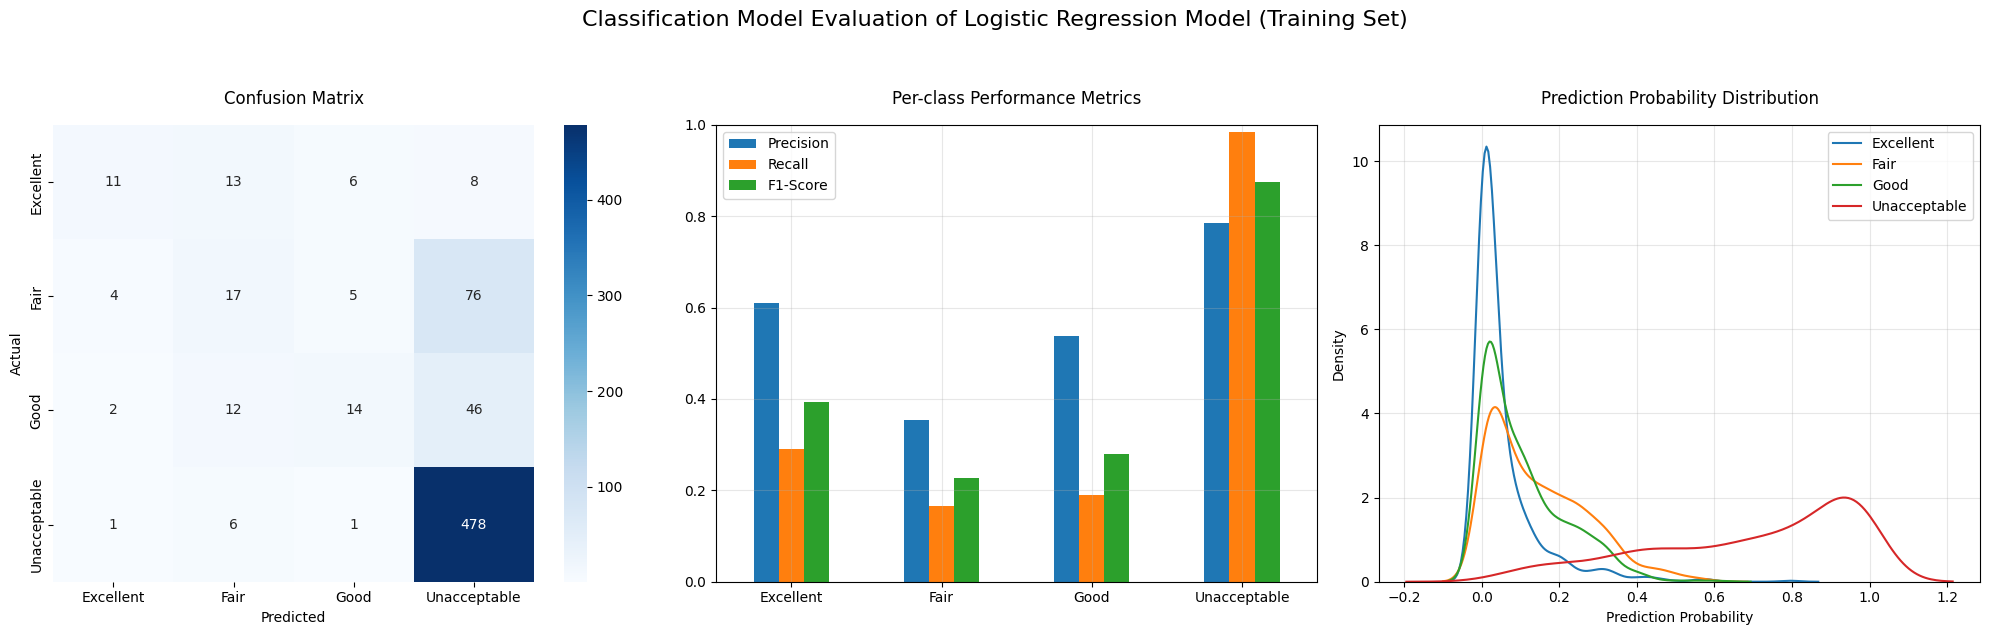

In [793]:
classification_evaluation(
    LogRegPipeline,
    X_train_clf,
    y_train_clf,
    "Logistic Regression Model (Training Set)"
)

In [ ]:
# Fit the preprocessor
preprocessor = preprocessor_onehot # Choose your desired preprocessor
preprocessor.fit(X_train_clf)

# Transform the data
input_train = preprocessor.transform(X_train_clf)
input_test = preprocessor.transform(X_test_clf)
input_val = preprocessor.transform(X_val_clf)

# Transform targets using LabelEncoder
target_train = encoder_le.fit_transform(y_train_clf)
target_test = encoder_le.transform(y_test_clf) # Use transform instead of fit_transform
target_val = encoder_le.transform(y_val_clf) # Use transform instead of fit_transform

In [823]:
# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(target_train),
    y=target_train
)
class_weights_dict = dict(enumerate(class_weights))

# Build the Neural Network model
NNClsModel = models.Sequential([
    layers.Input(shape=(input_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(target_train)), activation='softmax')
])

# Compile the model with appropriate loss function and optimizer
optimizer = Adam(learning_rate=0.001)
NNClsModel.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=10,
    min_lr=1e-5
)

# Model summary
NNClsModel.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_123 (Dense)               │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,692 (57.39 KB)

 Trainable params: 14,244 (55.64 KB)

 Non-trainable params: 448 (1.75 KB)

In [824]:
# Train the model
history = NNClsModel.fit(
    input_train,
    target_train,
    epochs=450,
    batch_size=32,
    class_weight=class_weights_dict,
    validation_data=(input_val, target_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/450
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2172 - loss: 2.3211 - val_accuracy: 0.3933 - val_loss: 1.3106 - learning_rate: 0.0010
Epoch 2/450
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2613 - loss: 2.1005 - val_accuracy: 0.4067 - val_loss: 1.2940 - learning_rate: 0.0010
Epoch 3/450
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2725 - loss: 1.9347 - val_accuracy: 0.4067 - val_loss: 1.2997 - learning_rate: 0.0010
Epoch 4/450
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2505 - loss: 1.8085 - val_accuracy: 0.3667 - val_loss: 1.3086 - learning_rate: 0.0010
Epoch 5/450
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2772 - loss: 1.7367 - val_accuracy: 0.3267 - val_loss: 1.3208 - learning_rate: 0.0010
Epoch 6/450
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2799 - loss: 1.7699 - val_accuracy: 0.3200 - val_loss: 1.3285 - learning_rate: 0.0010
Epoch 7/450
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2776 - loss: 1.6494 - val_acc

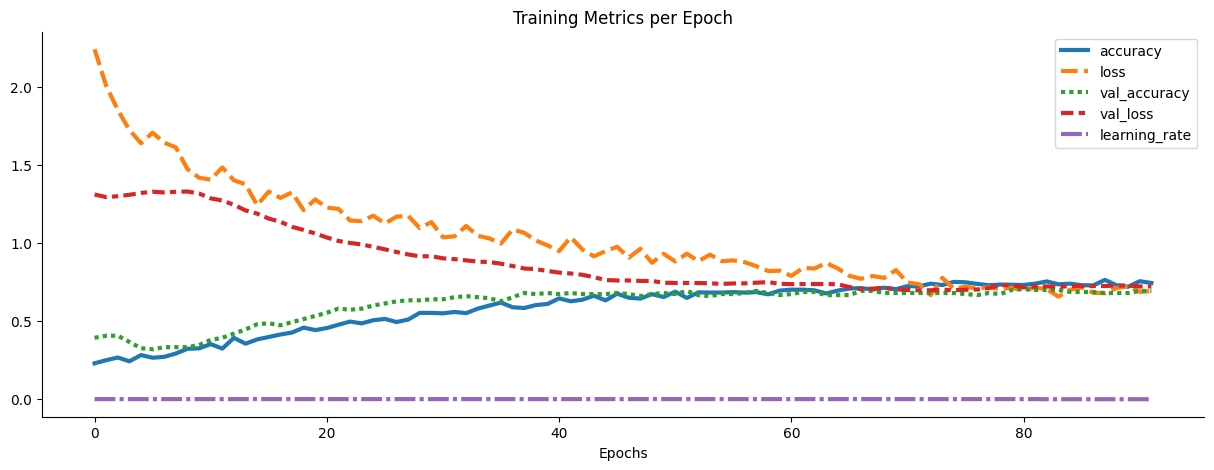

In [825]:
# Plot training history
losses = pd.DataFrame(history.history)
plt.figure(figsize=(15,5))
sns.lineplot(data=losses, lw=3)
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training Metrics per Epoch')
sns.despine()
plt.show()

In [826]:
# Create a wrapper class for the neural network model for compatibility with sklearn
class KerasClassifierWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model
        self.le = encoder_le  # Store the label encoder
        
    def fit(self, X, y=None):
        """Required for scikit-learn pipeline compatibility"""
        return self
        
    def predict(self, X):
        probs = self.model.predict(X, verbose=0)
        preds = np.argmax(probs, axis=1)
        return self.le.inverse_transform(preds)
    
    def predict_proba(self, X):
        return self.model.predict(X, verbose=0)

# Create wrapped model
NNClsWrapped = KerasClassifierWrapper(NNClsModel)

# Create pipeline for the Neural Network model
NNClsPipeline = create_pipeline(
    NNClsWrapped, 
    'onehot'
)

# Fit the pipeline (even though model is already trained)
NNClsPipeline.fit(
    X_train_clf,
    y_train_clf
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quenchTime', 'Nickel%',
                                                   'Iron%', 'Cobalt%',
                                                   'Chromium%', 'largeDefects',
                                                   'forgeTime', 'HeatTreatTime',
                                                   'sliverDefects',
                                                   'coolingRate',
                                                   'coolingRate^{2}',
                                                   'smallDefects',
                                                   'smallDefects^{2}']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['partType', 'microstructure',
                                                   'seedLocation',
                                                   'castType'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 KerasClassifierWrapper(model=<Sequential name=sequential_33, built=True>))])

--- Neural Network Classification Model (Training Set) Evaluation Metrics ---
-----------------------------------------------------------------------------
    Accuracy             : 0.84
    Weighted F1-Score    : 0.85
    Unacceptable Recall  : 0.85

    Per-class Precision:
        Excellent: 0.68
        Fair: 0.63
        Good: 0.61
        Unacceptable: 0.99
-----------------------------------------------------------------------------


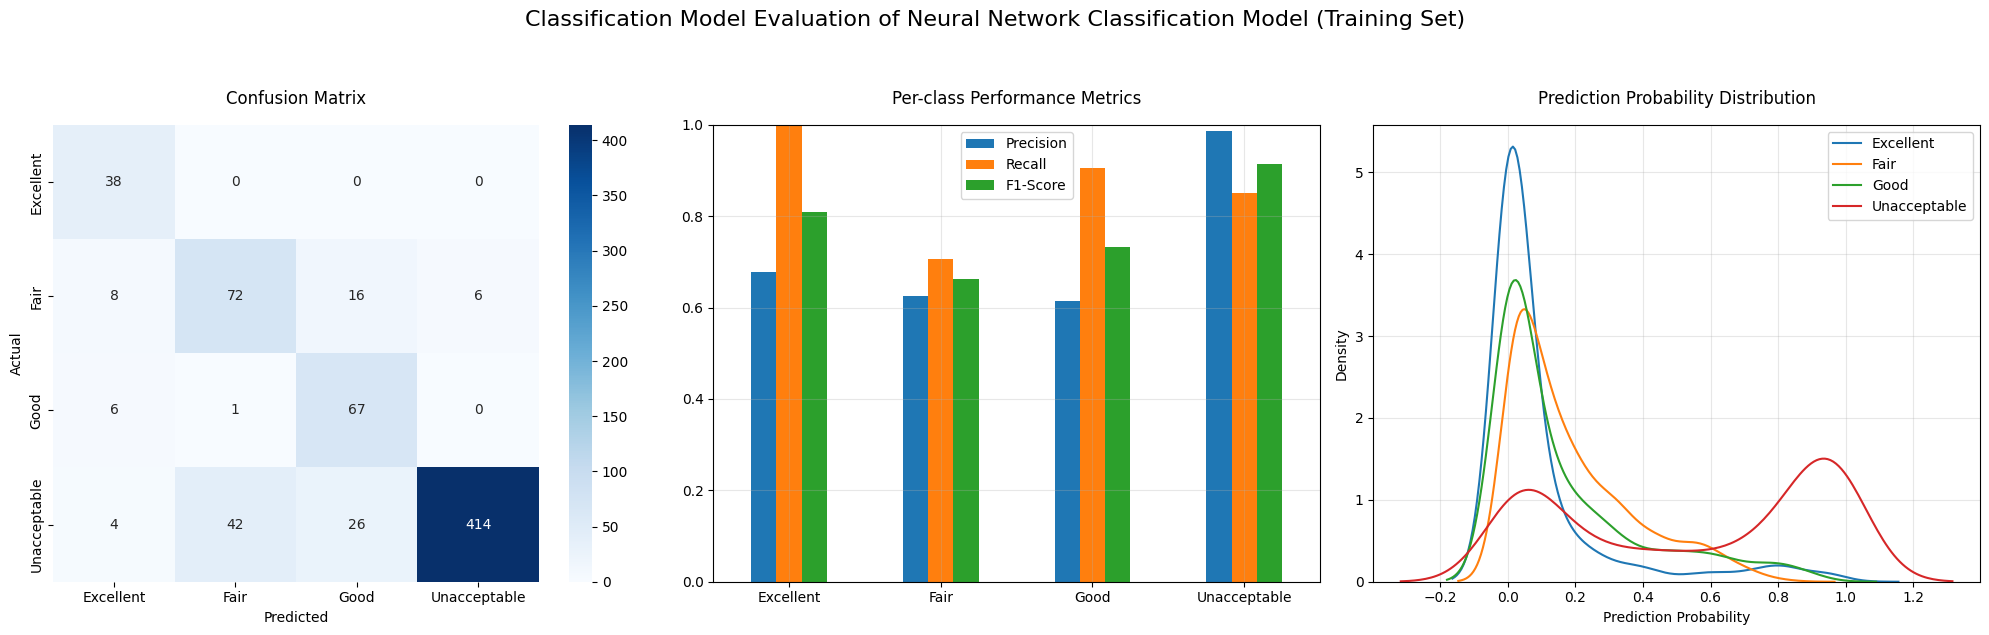

In [827]:
# Evaluate the model using the classification evaluation function
classification_evaluation(
    NNClsPipeline,
    X_train_clf,
    y_train_clf,
    "Neural Network Classification Model (Training Set)"
)

--- Neural Network Classification Model (Test Set) Evaluation Metrics ---
-------------------------------------------------------------------------
    Accuracy             : 0.70
    Weighted F1-Score    : 0.72
    Unacceptable Recall  : 0.81

    Per-class Precision:
        Excellent: 0.46
        Fair: 0.34
        Good: 0.25
        Unacceptable: 0.95
-------------------------------------------------------------------------


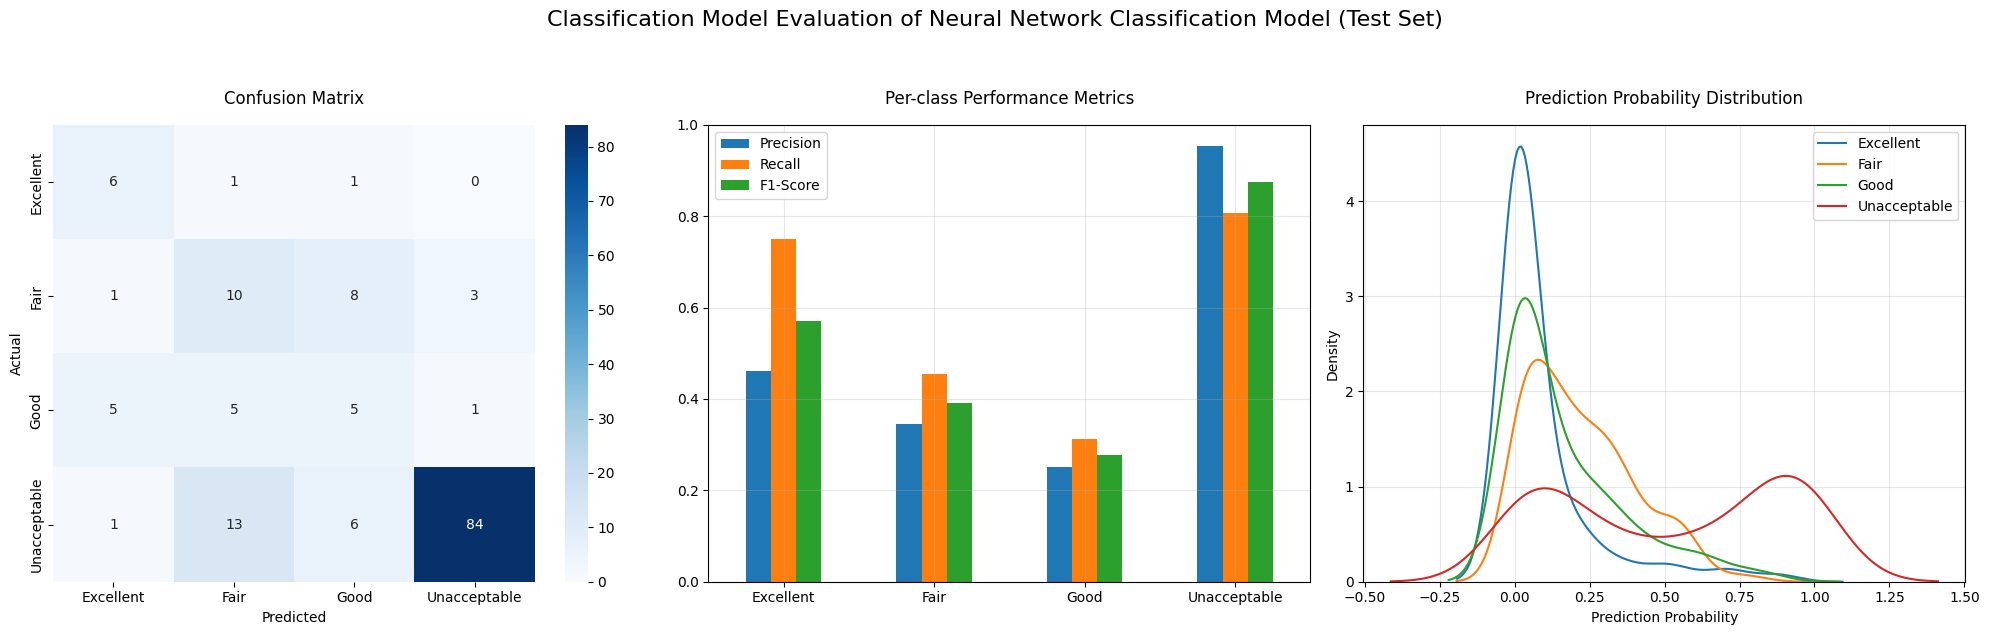

In [828]:
# Neural Network Classification Model (Test Set)
classification_evaluation(
    NNClsPipeline,
    X_test_clf,
    y_test_clf,
    "Neural Network Classification Model (Test Set)"
)